# Learning tasks - RobotArm

# Overall analysis 

In [71]:
import pandas as pd 
from distances import preprocess, euclidean_v2
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as ticker

from scipy.stats import mannwhitneyu, ttest_ind
from scipy import stats

import ast

In [72]:
import warnings
warnings.filterwarnings('ignore')

In [73]:
df = pd.read_csv("data/ldw_2023_pilot_coding_tasks_outputs_processed_3.csv")

L1 = "P1M120"
L2 = "P1M123"
L3 = "P1M124"

robotarm_df = df[df['Activity Name'] == 'RobotArm']
robotarm = robotarm_df[robotarm_df['Activity ID'] == L2]

key_vector_l1 = "['ra-world-arm,E,E,E,E,', 'E,E,E,E,E,', 'E,E,E,E,E,', 'E,E,E,E,E,', 'E,E,E,E,E,', 'E,E,E,E,ra-world-shape ra-world-shapeA,', 'E,E,E,E,ra-world-shape ra-world-shapeA,false']"
key_vector_l2 = "['ra-world-arm,E,E,E,E,', 'E,E,E,E,E,', 'E,E,E,E,E,', 'E,E,E,E,E,', 'E,E,E,E,E,', 'E,ra-world-shape ra-world-shapeB,E,ra-world-shape ra-world-shapeA,E,', 'E,ra-world-shape ra-world-shapeB,E,ra-world-shape ra-world-shapeA,E,false']"
key_vector_l3 = "['ra-world-arm,E,E,E,E,', 'E,E,E,E,E,', 'E,E,E,E,E,', 'E,E,E,E,E,', 'ra-world-shape ra-world-shapeA,E,E,E,E,', 'ra-world-shape ra-world-shapeA,ra-world-shape ra-world-shapeB,E,E,E,', 'ra-world-shape ra-world-shapeA,ra-world-shape ra-world-shapeB,E,E,E,false']"

initial_worldspace_l1 = "['ra-world-arm,E,E,E,E,', 'ra-world-arm,E,E,E,E,', 'E,E,E,E,E,', 'E,E,E,E,E,', 'E,E,E,E,E,', 'E,E,E,E,E,', 'ra-world-shape ra-world-shapeA,E,E,E,E,', 'ra-world-shape ra-world-shapeA,E,E,E,E,false']"
initial_worldspace_l2 = "['ra-world-arm,E,E,E,E,', 'ra-world-arm,E,E,E,E,', 'E,E,E,E,E,', 'E,E,E,E,E,', 'E,E,ra-world-shape ra-world-shapeB,E,E,', 'E,E,ra-world-shape ra-world-shapeA,E,E,', 'E,E,ra-world-shape ra-world-shapeA,E,E,', 'E,E,ra-world-shape ra-world-shapeB,E,E,false']"
initial_worldspace_l3 = "['ra-world-arm,E,E,E,E,', 'ra-world-arm,E,E,E,E,', 'E,E,E,E,E,', 'E,E,E,E,E,', 'E,E,E,E,E,', 'E,E,ra-world-shape ra-world-shapeB,E,E,', 'E,ra-world-shape ra-world-shapeA,ra-world-shape ra-world-shapeA,E,E,', 'E,ra-world-shape ra-world-shapeA,ra-world-shape ra-world-shapeB,E,E,false']" 

#################################### TO CHANGE ! ######################################################

#folder = "plots_version2/plot_l3"

robotarm_l1 = robotarm_df[robotarm_df['Activity ID'] == L1]
robotarm_l2 = robotarm_df[robotarm_df['Activity ID'] == L2]
robotarm_l3 = robotarm_df[robotarm_df['Activity ID'] == L3]

penalties = {'move1': 0.1, 'move2': 0.1, 'pickup1': 0.1, 'place1': 0.1}

initial_distance_l1 = euclidean_v2(initial_worldspace_l1, key_vector_l1, 0, 0, 0, 0, 0, penalties)
initial_distance_l2 = euclidean_v2(initial_worldspace_l2, key_vector_l2, 0, 0, 0, 0, 0, penalties)
initial_distance_l3 = euclidean_v2(initial_worldspace_l3, key_vector_l3, 0, 0, 0, 0, 0, penalties)

### Cleaning the data

In [74]:
# A bad worldspace is a worldspace which has more element than it should
def detect_longer_worldspace(v, goal_v): 
    v_matrix = preprocess(v)
    goal_matrix = preprocess(goal_v)
    
    more_elements = np.count_nonzero(v_matrix == 'A') > np.count_nonzero(goal_matrix == 'A') or np.count_nonzero(v_matrix == 'B') > np.count_nonzero(goal_matrix == 'B')   
    
    return more_elements

# worldspace which as no element at all (donc 30 E elements)
def detect_missing_worldspace(v, goal_v): 
    v_matrix = preprocess(v)
    goal_matrix = preprocess(goal_v)
    
    missing_A = np.count_nonzero(goal_matrix == 'A') - np.count_nonzero(v_matrix == 'A')
    missing_B = np.count_nonzero(goal_matrix == 'B') - np.count_nonzero(v_matrix == 'B')
    
    return missing_A > 1 or missing_B > 1

In [75]:
def cleaning_data(df, key_vector): 
    df = df.dropna(subset=['WorldSpace'])
    df = df[~df['WorldSpace'].str.contains("trial")]
    
    df['longer_worldspace'] = df.apply(lambda x: detect_longer_worldspace(x['WorldSpace'], key_vector), axis=1)
    
    # remove rows where bad_worldspace is True
    df = df[~df['longer_worldspace']]
    
    # remove the bad_worldspace column
    df = df.drop(columns=['longer_worldspace'])
    
    df['missing_worldspace'] = df.apply(lambda x: detect_missing_worldspace(x['WorldSpace'], key_vector), axis=1)
    
    # remove rows where missing_worldspace is True
    df = df[~df['missing_worldspace']]
    
    # remove the missing_worldspace column
    df = df.drop(columns=['missing_worldspace'])
    
    df_grouped = df.groupby('Student ID').apply(lambda x: 1 in x['WorldspaceScore'].values)

    # separate the students into two groups
    success_students = df_grouped[df_grouped == True].index
    failure_students = df_grouped[df_grouped == False].index
    
    # Sanity check to verify if the failing students do not overlap over the successful students (or vice-versa)
    if set(success_students.intersection(failure_students)) == set():
        print("Finished cleaning !")
    else: 
        print("Failing and successful students overlap: problem !")
    
    return df

In [76]:
def detect_error(worldspace):
    worldspace = worldspace.replace("ra-world-shape ra-world-shapeA", "A")
    worldspace = worldspace.replace("ra-world-shape ra-world-shapeB", "B")
    worldspace = ast.literal_eval(worldspace)
    
    matrix = []
    for i in range(len(worldspace)):
        matrix.append(worldspace[i].split(','))
        
    return int(matrix[-1][-1] != 'false')


def detect_type_error(worldspace, type_error):
    worldspace = worldspace.replace("ra-world-shape ra-world-shapeA", "A")
    worldspace = worldspace.replace("ra-world-shape ra-world-shapeB", "B")
    worldspace = ast.literal_eval(worldspace)
    
    matrix = []
    for i in range(len(worldspace)):
        matrix.append(worldspace[i].split(','))
    
    
    if matrix[-1][-1] == type_error:
        return 1
    else :
        return 0
    
    
def detect_missing_element(v, goal_v): 
    
    v_matrix = preprocess(v)
    goal_matrix = preprocess(goal_v)
    
    initial_count_A = np.count_nonzero(v_matrix == 'A')
    initial_count_B = np.count_nonzero(v_matrix == 'B')

    goal_count_A = np.count_nonzero(goal_matrix == 'A')
    goal_count_B = np.count_nonzero(goal_matrix == 'B')
        
    error = initial_count_A != goal_count_A or initial_count_B != goal_count_B
    
    return int(error)

In [77]:
def preprocessing_data(df, key_vector, initial_worldspace, code=False): 
    
    # Index the tentatives 
    df = df.groupby('Student ID', as_index=False).apply(lambda x: x.sort_values(by='timestamp')).reset_index(drop=True)
    df['index'] = df.groupby('Student ID').cumcount()
    
    # Selecting only useful informations 
    if code:
        data = df[["Student ID", "WorldSpace", "index", 'Submission_TreeDist_Successive']]
    else: 
        data = df[["Student ID", "WorldSpace", "index"]]

    # dictionnary to reassign index to the correct order, where index 0 becomes 1 and index 1 becomes 2
    index_dict = {i: i+1 for i in range(len(data['index'].unique()))}

    data['index'] = data['index'].apply(lambda x: index_dict[x])
    
    # Adding initial vector as starting point 
    
    initial_data = pd.DataFrame({'Student ID': data['Student ID'].unique(), 'WorldSpace': initial_worldspace, 'index': 0, 'Submission_TreeDist_Successive': 0})
    data = pd.concat([data, initial_data])

    data = data.groupby('Student ID', as_index=False).apply(lambda x: x.sort_values(by='index')).reset_index(drop=True)
    
    # create column max tentative which correspond to the last row column "index" for each student
    data["nb_tentative"] = data.groupby('Student ID')['index'].transform('max')
    
    # Create column corresponding to percentage of activity completed 
    data['pct_activity'] = data['index'] / data['nb_tentative']
    
    # Create column to indicate if the student made an error or not during the tentative
    data['error'] = data['WorldSpace'].apply(lambda x: detect_error(x))
    
    data['missing'] = data['WorldSpace'].apply(lambda x: detect_missing_element(x, key_vector))
    
    for error in ['move1', 'move2', 'pickup1', 'place1']:
        data[error] = data['WorldSpace'].apply(lambda x: detect_type_error(x, error))
        
    for x in ['error', 'missing', 'move1', 'move2', 'pickup1', 'place1']:
        data[f"nb_{x}"] = data.groupby('Student ID')[x].transform('sum')
        
    # Add percentage columns 
    for x in ['error', 'missing', 'move1', 'move2', 'pickup1', 'place1']:
        data[f'pct_{x}'] = data[f'nb_{x}'] / data['nb_tentative']
        
    # Compute euclidean distance 
    for idx, row in data.iterrows():
        missing = row['missing']
        move1 = row['move1']
        move2 = row['move2']
        pickup1 = row['pickup1']
        place1 = row['place1']
        
        data.loc[idx, 'euclidean_distance'] = euclidean_v2(row['WorldSpace'], key_vector, move1, move2, 
                                                            place1, pickup1, missing, penalties)
        
    # Compute euclidean distance successively 
    for idx, row in data.iterrows(): 
        if row['index'] == 0: 
            data.loc[idx, 'delta_successive'] = 0
        else: 
            data.loc[idx, 'delta_successive'] = euclidean_v2(data.loc[idx, 'WorldSpace'], data.loc[idx-1, 'WorldSpace'], 
                                            data.loc[idx, 'move1'], data.loc[idx, 'move2'], data.loc[idx, 'place1'], 
                                            data.loc[idx, 'pickup1'], data.loc[idx, 'missing'], penalties)
            
    # Separate successful and failing students 
    df_grouped = df.groupby('Student ID').apply(lambda x: 1 in x['WorldspaceScore'].values)

    success_students = df_grouped[df_grouped == True].index
    failure_students = df_grouped[df_grouped == False].index
    
    data_success = data[data['Student ID'].isin(success_students)]
    data_fail = data[data['Student ID'].isin(failure_students)]
    
    data_success['success'] = 1
    data_fail['success'] = 0
    
    data = pd.concat([data_success, data_fail])
    
    # Separate students with an error or not
    error_student = data[data['nb_error'] != 0]['Student ID'].unique()
    no_error_student = data[data['nb_error'] == 0]['Student ID'].unique()
    
    data_error = data[data['Student ID'].isin(error_student)]
    data_no_error = data[data['Student ID'].isin(no_error_student)]
    
    data_error['has_error'] = 1
    data_no_error['has_error'] = 0
    
    data = pd.concat([data_error, data_no_error])
    
    for idx, row in data.iterrows():
        if row['move1'] == 1: 
            data.loc[idx, 'seq_error'] = 'move1'
        elif row['move2'] == 1:
            data.loc[idx, 'seq_error'] = 'move2'
        elif row['pickup1'] == 1:
            data.loc[idx, 'seq_error'] = 'pickup1'
        elif row['place1'] == 1:
            data.loc[idx, 'seq_error'] = 'place1'
        else: 
            data.loc[idx, 'seq_error'] = 'none'
            
    for idx, row in data.iterrows():
        if row['error'] == 1 and row['missing'] == 1:  
            data.loc[idx, 'cases'] = 'case1'
        elif row['error'] == 1 and row['missing'] != 1:
            data.loc[idx, 'cases'] = 'case2'
        elif row['error'] != 1 and row['missing'] == 1:
            data.loc[idx, 'cases'] = 'case3'
        else:
            data.loc[idx, 'cases'] = 'none'
    
    return data

In [78]:
def grouped_per_student(df): 
    data_grouped_per_student = df.groupby('Student ID').agg({'euclidean_distance': 'mean', 'delta_successive': 'mean', 'nb_tentative': 'max', 
                                                           'nb_error': 'max', 'nb_move1': 'max', 'nb_move2': 'max', 
                                                           'nb_pickup1': 'max', 'nb_place1': 'max', 'pct_error': 'max', 
                                                           'pct_move1': 'max', 'pct_move2': 'max', 'pct_pickup1': 'max', 
                                                           'pct_place1': 'max', 'success': 'max', 'has_error': 'max'})
    data_grouped_per_student.columns = ['mean_euclidean_distance', 'mean_delta_successive', 'nb_tentative', 'nb_error', 'nb_move1', 
                                    'nb_move2', 'nb_pickup1', 'nb_place1', 'pct_error', 'pct_move1', 
                                    'pct_move2', 'pct_pickup1', 'pct_place1', 'success', 'has_error']
    

    return data_grouped_per_student

# Cleaning & Preprocessing

In [79]:
robotarm_l1 = cleaning_data(robotarm_l1, key_vector_l1)
robotarm_l2 = cleaning_data(robotarm_l2, key_vector_l2)
robotarm_l3 = cleaning_data(robotarm_l3, key_vector_l3)

robotarm_l1 = preprocessing_data(robotarm_l1, key_vector_l1, initial_worldspace_l1)
robotarm_l2 = preprocessing_data(robotarm_l2, key_vector_l2, initial_worldspace_l2)
robotarm_l3 = preprocessing_data(robotarm_l3, key_vector_l3, initial_worldspace_l3)

Finished cleaning !
Finished cleaning !
Finished cleaning !


In [80]:
robotarm_l1.to_csv("data/robotarm_l1.csv", index=False)
robotarm_l2.to_csv("data/robotarm_l2.csv", index=False)
robotarm_l3.to_csv("data/robotarm_l3.csv", index=False)

In [81]:
robotarm_l1['activity'] = 1
robotarm_l2['activity'] = 2
robotarm_l3['activity'] = 3

robotarm = pd.concat([robotarm_l1, robotarm_l2, robotarm_l3])

robotarm.to_csv("data/robotarm.csv", index=False)

# Quantify the difference of trajectories 

In [213]:
def plot_euclidean_per_tentative(df, metric, estimator, task_name):
    tot_tentatives = [1, 2, 3, 4, 5, 6, 7, 8, 9]

    fig, axs = plt.subplots(3, 3, figsize=(15, 12))

    for i, ax in enumerate(axs.flat):
        if i < len(tot_tentatives):
            grouped_data = df[df['nb_tentative'] == tot_tentatives[i]]
            
            df_success = df[df['success'] == 1]
            df_fail = df[df['success'] == 0]
            
            # count number of failing and successful students
            nb_fail_student = len(df_fail[df_fail['nb_tentative'] == tot_tentatives[i]]['Student ID'].unique())
            nb_success_student = len(df_success[df_success['nb_tentative'] == tot_tentatives[i]]['Student ID'].unique())
            
            if estimator == 'mean':
                estimator = np.mean
            elif estimator == 'median':
                estimator = np.median

            sns.lineplot(data=grouped_data, y=metric, x='index', hue="success",
                        err_style="band", errorbar ='ci', estimator=estimator, ci=95, ax=ax, legend=True)
            
            #ax.set_ylim(0, 1)
            ax.set_title(f"Total Tentatives: {tot_tentatives[i]}")
            ax.set_xlabel("Tentative")
            ax.set_ylabel("Euclidean distance")
            ax.xaxis.set_major_locator(ticker.MaxNLocator(integer=True))
            
            handles, labels = ax.get_legend_handles_labels()
            new_labels = []
            for label in labels:
                if label == '0':
                    new_labels.append(f"Failing, N={nb_fail_student}")
                else:
                    new_labels.append(f"Success, N={nb_success_student}")
            ax.legend(handles, new_labels, loc='upper right', fontsize=9)
            
        else:
            ax.axis('off')

    plt.suptitle(f"Euclidean distance per tentative for {task_name} task")
    plt.tight_layout()
    #plt.savefig(f"{folder}/lineplot_euclidean_distance_error_no_error_tentatives_fail_multi.png")
    plt.show()

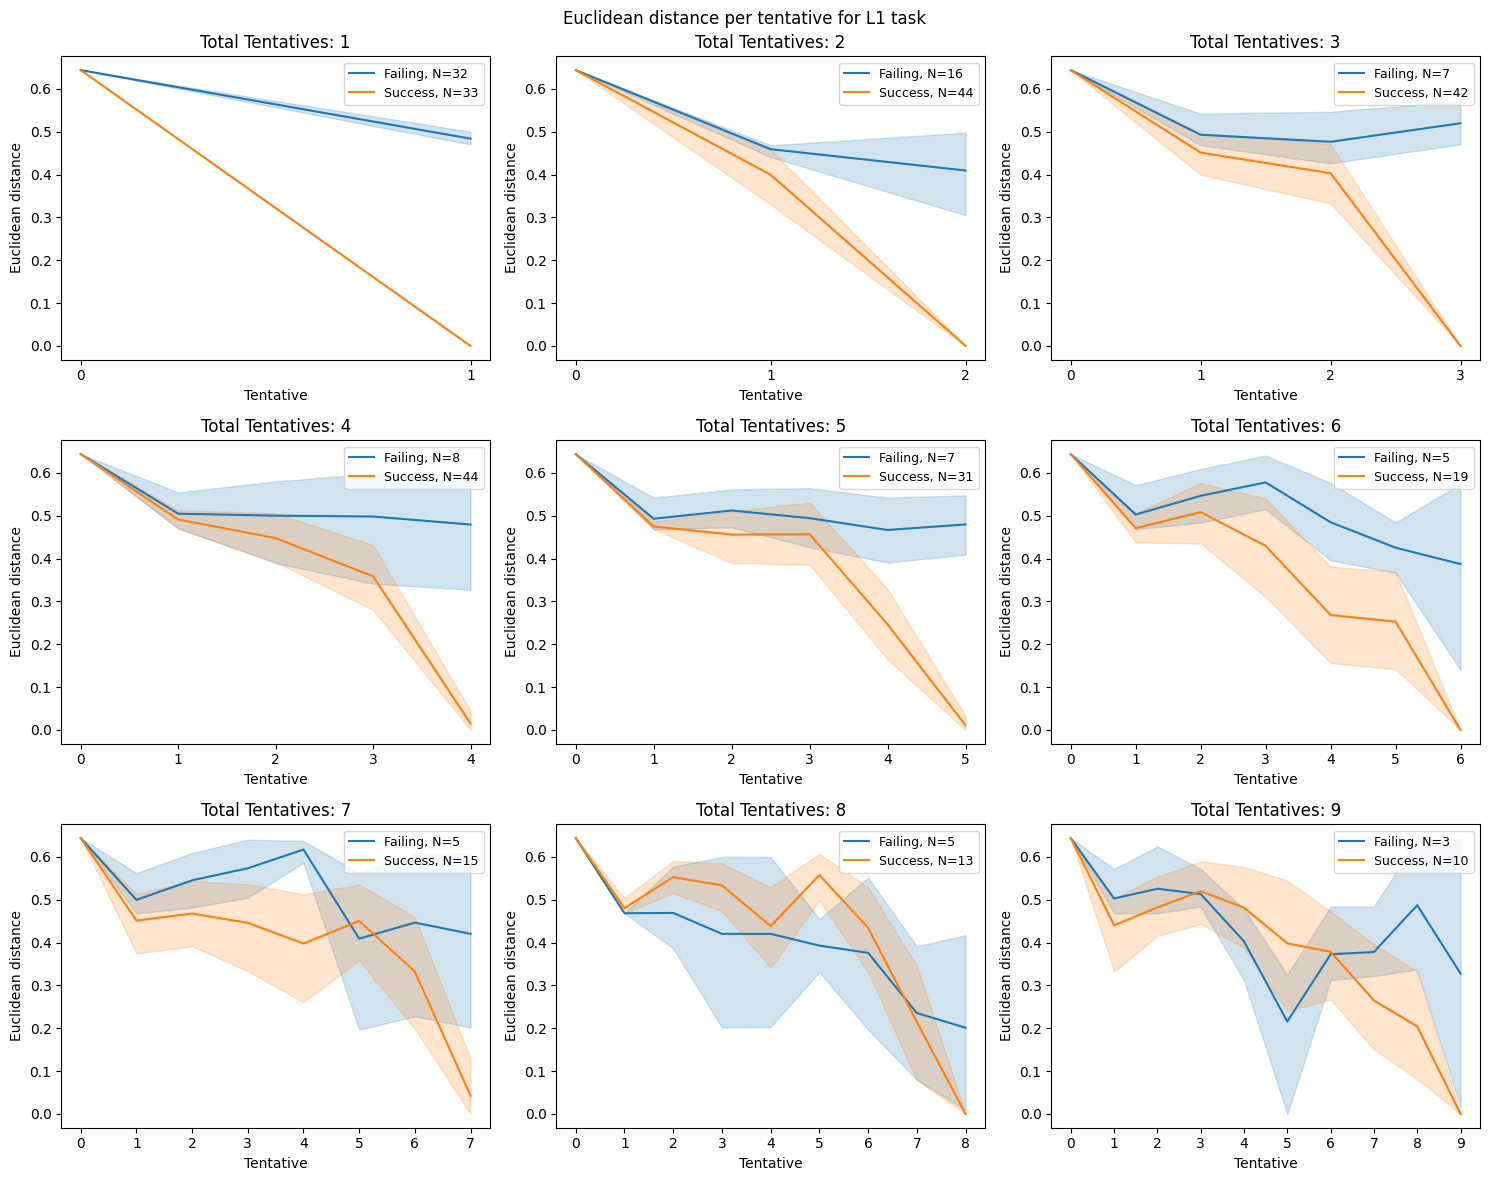

In [214]:
plot_euclidean_per_tentative(robotarm_l1, 'euclidean_distance', 'mean', 'L1')

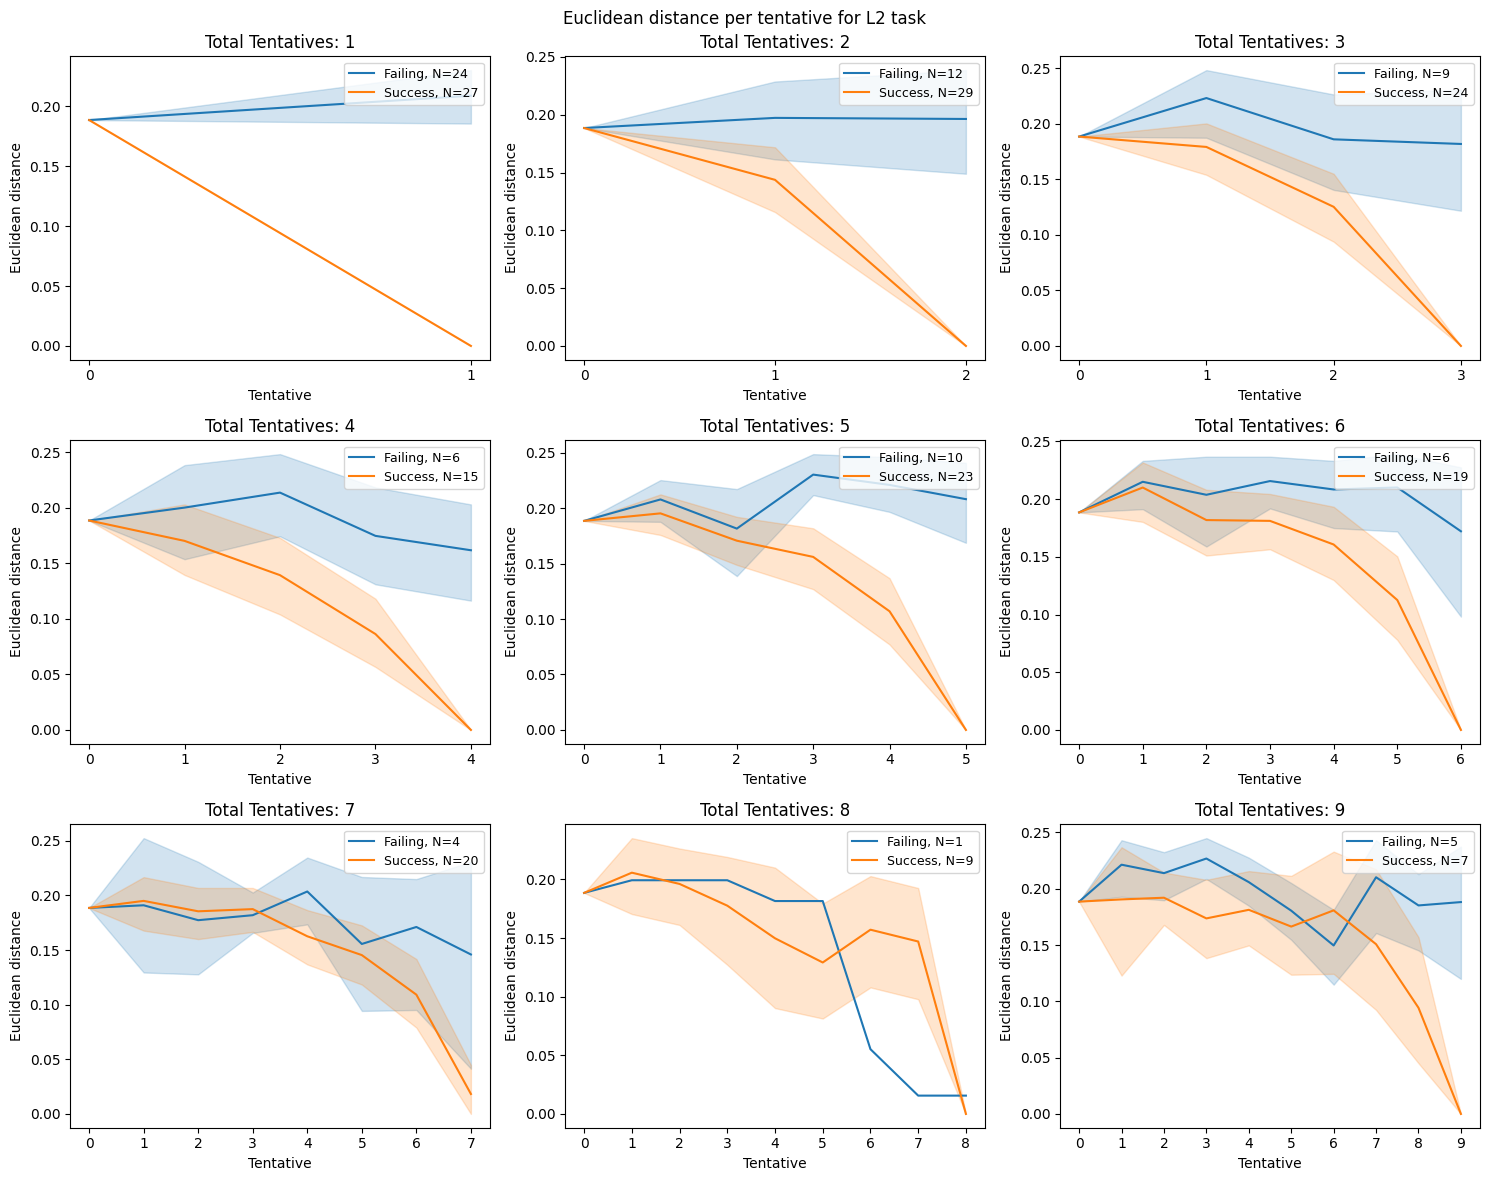

In [215]:
plot_euclidean_per_tentative(robotarm_l2, 'euclidean_distance', 'mean', 'L2')

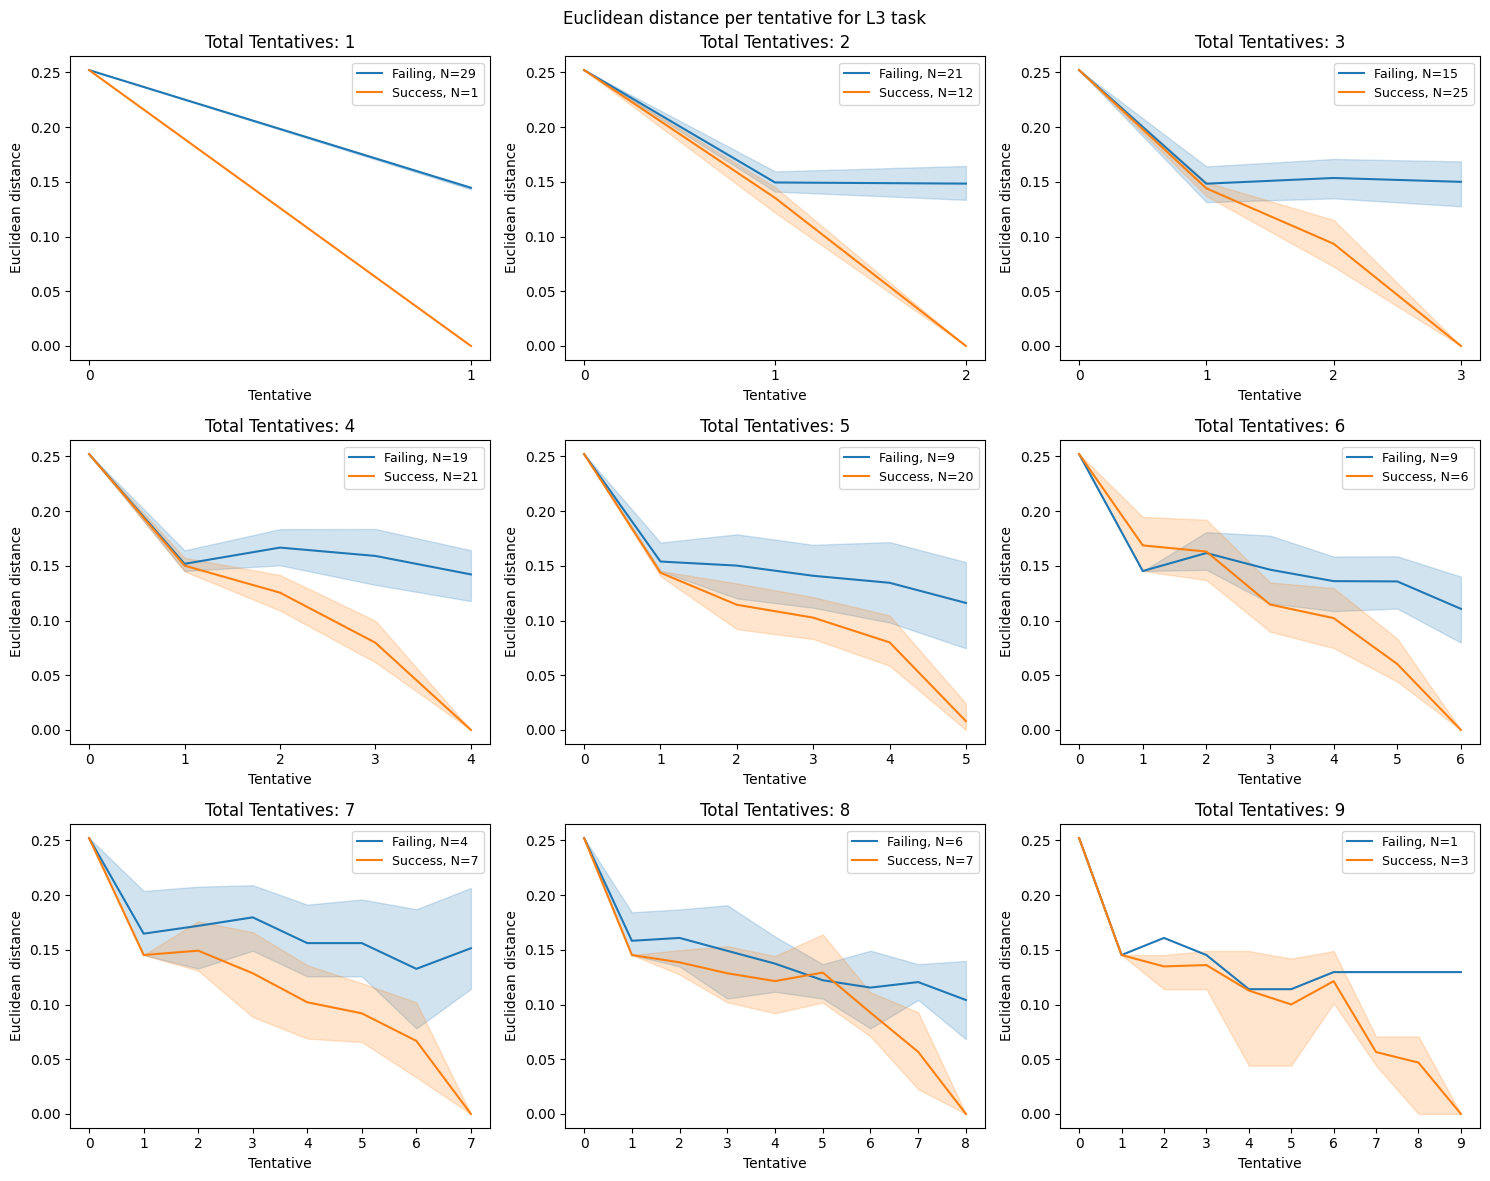

In [216]:
plot_euclidean_per_tentative(robotarm_l3, 'euclidean_distance', 'mean', 'L3')

In [219]:
# write the cleaned data to a csv file
robotarm_l1.to_csv("data/robotarm_l1_cleaned.csv")
robotarm_l2.to_csv("data/robotarm_l2_cleaned.csv")
robotarm_l3.to_csv("data/robotarm_l3_cleaned.csv")

### Quantify the point of deviation between both trajectories (failing and successful students)

In [32]:
# construct dataset of the difference between euclidean distance between successful and failing students

def euclidean_difference(df, task_name):
    
    df_success = df[df['success'] == 1]
    df_fail = df[df['success'] == 0]
    
    df_grouped_success = df_success.groupby('nb_tentative').agg({'euclidean_distance': 'mean', 'nb_tentative': 'max'})
    df_grouped_success.columns = ['euclidean_distance_success', 'tot_tentative']
    df_grouped_fail = df_fail.groupby('nb_tentative').agg({'euclidean_distance': 'mean', 'nb_tentative': 'max'})
    df_grouped_fail.columns = ['euclidean_distance_fail', 'tot_tentative']
    
    df_grouped = df_grouped_success.merge(df_grouped_fail, on='tot_tentative', suffixes=('_success', '_fail'))
    
    tentatives_success = df_grouped_success['tot_tentative'].unique()
    tentatives_fail = df_grouped_fail['tot_tentative'].unique()
    
    tentatives = list(set(tentatives_success).intersection(set(tentatives_fail)))
    
    df_grouped = df_grouped[df_grouped['tot_tentative'].isin(tentatives)]

    df_grouped['difference'] = df_grouped['euclidean_distance_success'] - df_grouped['euclidean_distance_fail']
    df_grouped['difference'] = df_grouped['difference'].abs()

    
    return df_grouped

In [53]:
def euclidean_difference_tentative(df, tentatives, threshold):
    df_tentative = df[df['nb_tentative'] == tentatives]
    
    df_success = df_tentative[df_tentative['success'] == 1]
    df_fail = df_tentative[df_tentative['success'] == 0]
    
    df_grouped_success = df_success.groupby('pct_activity').agg({'euclidean_distance': 'mean', 'pct_activity': 'max'})
    df_grouped_fail = df_fail.groupby('pct_activity').agg({'euclidean_distance': 'mean', 'pct_activity': 'max'})
    
    df_grouped_success.columns = ['euclidean_distance_success', 'index']
    df_grouped_fail.columns = ['euclidean_distance_fail', 'index']
    
    df_grouped = df_grouped_success.merge(df_grouped_fail, on='index', suffixes=('_success', '_fail'))
    
    df_grouped['difference'] = df_grouped['euclidean_distance_success'] - df_grouped['euclidean_distance_fail']
    
    df_grouped['difference'] = df_grouped['difference'].abs()
    
    df_grouped = df_grouped[df_grouped['difference'] > threshold]
    
    min_pct_activity = df_grouped['index'].min()
    
    return df_grouped, min_pct_activity

For the L1 task 

In [33]:
euclidean_difference_l1 = euclidean_difference(robotarm_l1, 'L1')

In [34]:
euclidean_difference_l1

euclidean_distance_success  tot_tentative  euclidean_distance_fail  \
0                     0.321960              1                 0.563936   
1                     0.347966              2                 0.504288   
2                     0.374603              3                 0.533352   
3                     0.391315              4                 0.525346   
4                     0.381562              5                 0.515047   
5                     0.367778              6                 0.509848   
6                     0.404115              7                 0.519519   
7                     0.428572              8                 0.403187   
8                     0.381458              9                 0.437091   
9                     0.399338             10                 0.436851   
10                    0.435385             11                 0.502960   
11                    0.443340             12                 0.482014   
12                    0.425212             13                 0.513534   
13                    0.369162             14                 0.520100   
14                    0.414319             15                 0.527388   
15                    0.429129             16                 0.528024   

    difference  
0     0.241976  
1     0.156321  
2     0.158748  
3     0.134031  
4     0.133485  
5     0.142070  
6     0.115403  
7     0.025386  
8     0.055633  
9     0.037513  
10    0.067575  
11    0.038673  
12    0.088322  
13    0.150938  
14    0.113069  
15    0.098895

We consider uniquely the tentatives until 9, because others are mostly outliers

In [97]:
tentatives = [1, 2, 3, 4, 5, 6, 7, 8, 9]
thresholds = euclidean_difference_l1.loc[euclidean_difference_l1['tot_tentative'].isin(tentatives)]['difference'].values

pct_activity = []

for i in range(len(tentatives)):
    df_grouped, min_pct_activity = euclidean_difference_tentative(robotarm_l1, tentatives[i], thresholds[i])
    pct_activity.append(min_pct_activity)

In [98]:
np.mean(pct_activity)

0.6488536155202822

For the L2 task 

In [110]:
euclidean_difference_l2 = euclidean_difference(robotarm_l2, 'L2')
euclidean_difference_l2

euclidean_distance_success  tot_tentative  euclidean_distance_fail  \
0                     0.094259              1                 0.198665   
1                     0.110739              2                 0.194055   
2                     0.123242              3                 0.194906   
3                     0.116859              4                 0.187733   
4                     0.136240              5                 0.206190   
5                     0.147837              6                 0.201949   
6                     0.148956              7                 0.176842   
7                     0.150130              8                 0.137333   
8                     0.151792              9                 0.196971   
9                     0.141951             10                 0.195460   
10                    0.146245             11                 0.176389   
11                    0.133958             13                 0.182379   
12                    0.144781             14                 0.176610   
13                    0.144245             17                 0.173641   
14                    0.171235             19                 0.118390   

    difference  
0     0.104406  
1     0.083317  
2     0.071665  
3     0.070874  
4     0.069950  
5     0.054112  
6     0.027886  
7     0.012797  
8     0.045179  
9     0.053510  
10    0.030145  
11    0.048422  
12    0.031829  
13    0.029397  
14    0.052845

In [111]:
tentatives = [1, 2, 3, 4, 5, 6, 7, 8, 9]
thresholds = euclidean_difference_l2.loc[euclidean_difference_l2['tot_tentative'].isin(tentatives)]['difference'].values

pct_activity = []

for i in range(len(tentatives)):
    df_grouped, min_pct_activity = euclidean_difference_tentative(robotarm_l2, tentatives[i], thresholds[i])
    pct_activity.append(min_pct_activity)

In [112]:
np.mean(pct_activity)

0.6903439153439153

For L3 task 

In [113]:
euclidean_difference_l3 = euclidean_difference(robotarm_l3, 'L3')
euclidean_difference_l3

euclidean_distance_success  tot_tentative  euclidean_distance_fail  \
0                    0.126049              1                 0.198324   
1                    0.129155              2                 0.183287   
2                    0.122374              3                 0.175975   
3                    0.121485              4                 0.174354   
4                    0.116823              5                 0.157950   
5                    0.122987              6                 0.155422   
6                    0.116990              7                 0.170601   
7                    0.118272              8                 0.146670   
8                    0.110587              9                 0.145003   
9                    0.129065             11                 0.122040   

   difference  
0    0.072275  
1    0.054132  
2    0.053601  
3    0.052869  
4    0.041127  
5    0.032435  
6    0.053611  
7    0.028398  
8    0.034416  
9    0.007025

In [114]:
tentatives = [1, 2, 3, 4, 5, 6, 7, 8, 9]
thresholds = euclidean_difference_l3.loc[euclidean_difference_l3['tot_tentative'].isin(tentatives)]['difference'].values

pct_activity = []

for i in range(len(tentatives)):
    df_grouped, min_pct_activity = euclidean_difference_tentative(robotarm_l3, tentatives[i], thresholds[i])
    pct_activity.append(min_pct_activity)

In [115]:
np.mean(pct_activity)

0.789726631393298

## Comparison of Code Space and World Space

In [82]:
df_code = pd.read_csv("data/data_code_space.csv")

In [83]:
df_code

Unnamed: 0 Activity ID Student ID     timestamp  \
0                0      P1M120  AUS123001  1.675726e+12   
1                1      P1M120  AUS123001  1.675726e+12   
2                2      P1M120  AUS123001  1.675726e+12   
3                3      P1M120  AUS123001  1.675726e+12   
4                4      P1M120  AUS123001  1.675726e+12   
...            ...         ...        ...           ...   
112735      303059      P1M128   UK123025  1.679392e+12   
112736      303060      P1M128   UK123025  1.679392e+12   
112737      303061      P1M128   UK123025  1.679392e+12   
112738      303062      P1M128   UK123025  1.679392e+12   
112739      303063      P1M128   UK123025  1.679392e+12   

                                                      XML  \
0                                                     NaN   
1                                                     NaN   
2       <xml><block type="when_run" id="F:Jwyr$x*0+PK....   
3       <xml><block type="when_run" id="F:Jwyr$x*0+PK....   
4                                                     NaN   
...                                                   ...   
112735  <xml><block type="when_run" id="GW9[iP:_xJ%eAr...   
112736                                                NaN   
112737  <xml><block type="when_run" id="GW9[iP:_xJ%eAr...   
112738                                                NaN   
112739                                                NaN   

                                                Clean_XML  \
0                                                     NaN   
1                                                     NaN   
2       <root><run type="when_run" /><for type="g_repe...   
3       <root><run type="when_run" /><for type="g_repe...   
4                                                     NaN   
...                                                   ...   
112735  <root><run type="when_run" /><for type="g_repe...   
112736                                                NaN   
112737  <root><run type="when_run" /><for type="g_repe...   
112738                                                NaN   
112739                                                NaN   

                 Submission_CleanXMLPrevious  \
0                                        NaN   
1                                        NaN   
2                                        NaN   
3       <root><run type="when_run" /></root>   
4                                        NaN   
...                                      ...   
112735                                   NaN   
112736                                   NaN   
112737                                   NaN   
112738                                   NaN   
112739                                   NaN   

                                    Edit_CleanXMLPrevious  \
0                                                     NaN   
1                                                     NaN   
2                    <root><run type="when_run" /></root>   
3       <root><run type="when_run" /><for type="g_repe...   
4                                                     NaN   
...                                                   ...   
112735  <root><run type="when_run" /><for type="g_repe...   
112736                                                NaN   
112737  <root><run type="when_run" /><for type="g_repe...   
112738                                                NaN   
112739                                                NaN   

        Submission_TreeDist_LastSubmission  Submission_TreeDist_Successive  \
0                                      NaN                             NaN   
1                                      NaN                             NaN   
2                                      NaN                             NaN   
3                                      2.0                             5.0   
4                                      NaN                             NaN   
...                                    ...             

In [84]:
df_code.isnull().sum()

Unnamed: 0                                 0
Activity ID                                0
Student ID                                 0
timestamp                                  0
XML                                    70530
Clean_XML                              70530
Submission_CleanXMLPrevious           105582
Edit_CleanXMLPrevious                  70530
Submission_TreeDist_LastSubmission    105582
Submission_TreeDist_Successive        105582
Edit_TreeDist_LastSubmission           70530
Edit_TreeDist_Successive               70530
Submission_TreeSizeChange             105582
Edit_TreeSizeChange                    70530
dtype: int64

In [85]:
df_code['Activity ID'].unique()

array(['P1M120', 'P1M124', 'P1M123', 'P1M128'], dtype=object)

In [86]:
df = df[df['Activity ID'].isin(['P1M120', 'P1M123', 'P1M124', 'P1M128'])]

In [87]:
df_code = df_code.drop(columns=['Unnamed: 0'])

In [88]:
df_code = df_code.dropna(subset=['XML'])

In [89]:
df_code.isnull().sum()

Activity ID                               0
Student ID                                0
timestamp                                 0
XML                                       0
Clean_XML                                 0
Submission_CleanXMLPrevious           35052
Edit_CleanXMLPrevious                     0
Submission_TreeDist_LastSubmission    35052
Submission_TreeDist_Successive        35052
Edit_TreeDist_LastSubmission              0
Edit_TreeDist_Successive                  0
Submission_TreeSizeChange             35052
Edit_TreeSizeChange                       0
dtype: int64

In [90]:
# merge dataframes on Student ID and Activity ID and timestamp
df_tot = df.merge(df_code, on=['Student ID', 'Activity ID', 'timestamp'])

In [91]:
df_tot.columns

Index(['Unnamed: 0', 'Filename', 'Activity Name', 'Activity Type', 'events',
       'Activity ID', 'Student ID', 'timestamp', 'event_action', 'event_id',
       'XML_x', 'd_workspaceResult', 'WorldSpace', 'WorldspaceScore', 'XML_y',
       'Clean_XML', 'Submission_CleanXMLPrevious', 'Edit_CleanXMLPrevious',
       'Submission_TreeDist_LastSubmission', 'Submission_TreeDist_Successive',
       'Edit_TreeDist_LastSubmission', 'Edit_TreeDist_Successive',
       'Submission_TreeSizeChange', 'Edit_TreeSizeChange'],
      dtype='object')

In [92]:
df_tot.isnull().sum()

Unnamed: 0                               0
Filename                                 0
Activity Name                            0
Activity Type                            0
events                                   0
Activity ID                              0
Student ID                               0
timestamp                                0
event_action                             0
event_id                                 0
XML_x                                    0
d_workspaceResult                     1247
WorldSpace                            1247
WorldspaceScore                       1247
XML_y                                    0
Clean_XML                                0
Submission_CleanXMLPrevious           1247
Edit_CleanXMLPrevious                    0
Submission_TreeDist_LastSubmission    1247
Submission_TreeDist_Successive        1247
Edit_TreeDist_LastSubmission             0
Edit_TreeDist_Successive                 0
Submission_TreeSizeChange             1247
Edit_TreeSi

In [93]:
df_tot = df_tot.dropna(subset=['WorldSpace'])

In [94]:
df_tot.isnull().sum()

Unnamed: 0                            0
Filename                              0
Activity Name                         0
Activity Type                         0
events                                0
Activity ID                           0
Student ID                            0
timestamp                             0
event_action                          0
event_id                              0
XML_x                                 0
d_workspaceResult                     0
WorldSpace                            0
WorldspaceScore                       0
XML_y                                 0
Clean_XML                             0
Submission_CleanXMLPrevious           0
Edit_CleanXMLPrevious                 0
Submission_TreeDist_LastSubmission    0
Submission_TreeDist_Successive        0
Edit_TreeDist_LastSubmission          0
Edit_TreeDist_Successive              0
Submission_TreeSizeChange             0
Edit_TreeSizeChange                   0
dtype: int64

In [95]:
data = df_tot[['Student ID', 'WorldSpace', 'Activity ID', 'timestamp', 'WorldspaceScore', 'Submission_TreeDist_LastSubmission', 'Submission_TreeDist_Successive', 'Submission_TreeSizeChange']]

In [96]:
data_l1 = data[data['Activity ID'] == 'P1M120']
data_l2 = data[data['Activity ID'] == 'P1M123']
data_l3 = data[data['Activity ID'] == 'P1M124']

data_l1 = cleaning_data(data_l1, key_vector_l1)
data_l2 = cleaning_data(data_l2, key_vector_l2)
data_l3 = cleaning_data(data_l3, key_vector_l3)

data_l1 = preprocessing_data(data_l1, key_vector_l1, initial_worldspace_l1, code=True)
data_l2 = preprocessing_data(data_l2, key_vector_l2, initial_worldspace_l2, code=True)
data_l3 = preprocessing_data(data_l3, key_vector_l3, initial_worldspace_l3, code=True)


Finished cleaning !
Finished cleaning !
Finished cleaning !


In [99]:
data_l1['activity'] = 1
data_l2['activity'] = 2
data_l3['activity'] = 3

data = pd.concat([data_l1, data_l2, data_l3])

In [100]:
data.columns

Index(['Student ID', 'WorldSpace', 'index', 'Submission_TreeDist_Successive',
       'nb_tentative', 'pct_activity', 'error', 'missing', 'move1', 'move2',
       'pickup1', 'place1', 'nb_error', 'nb_missing', 'nb_move1', 'nb_move2',
       'nb_pickup1', 'nb_place1', 'pct_error', 'pct_missing', 'pct_move1',
       'pct_move2', 'pct_pickup1', 'pct_place1', 'euclidean_distance',
       'delta_successive', 'success', 'has_error', 'seq_error', 'cases',
       'activity'],
      dtype='object')

Text(0.5, 0, 'Percentage of activity')

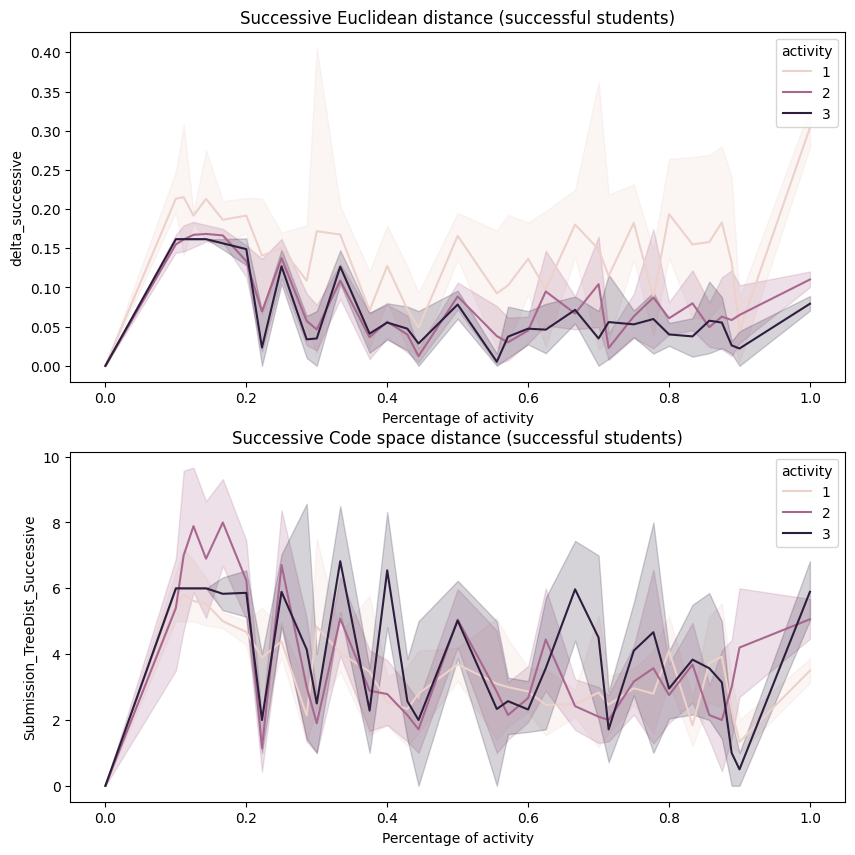

In [104]:
fig, axs = plt.subplots(2, 1, figsize=(10, 10))

data_filtered = data[data['nb_tentative'] <= 10]
data_filtered_success = data_filtered[data_filtered['success'] == 1]

sns.lineplot(data=data_filtered_success, x='pct_activity', y='delta_successive', estimator='mean', hue='activity', ci=95, ax=axs[0])
sns.lineplot(data=data_filtered_success, x='pct_activity', y='Submission_TreeDist_Successive', estimator='mean', hue='activity', ci=95, ax=axs[1])

axs[0].set_title(f"Successive Euclidean distance (successful students)")
axs[0].set_xlabel("Percentage of activity")

axs[1].set_title(f"Successive Code space distance (successful students)")
axs[1].set_xlabel("Percentage of activity")


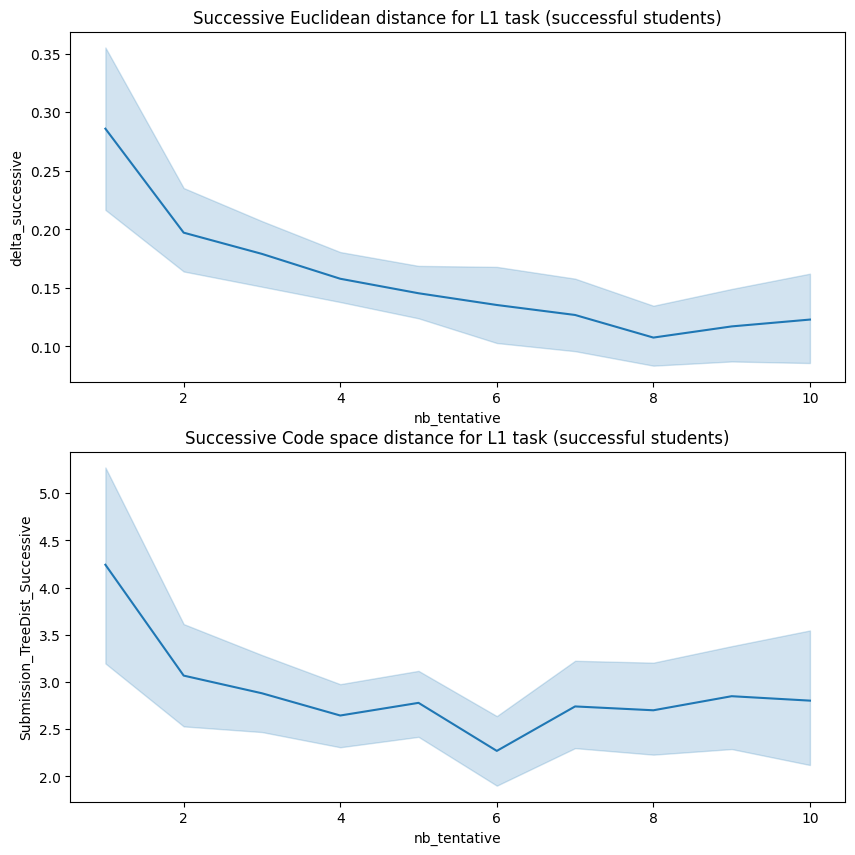

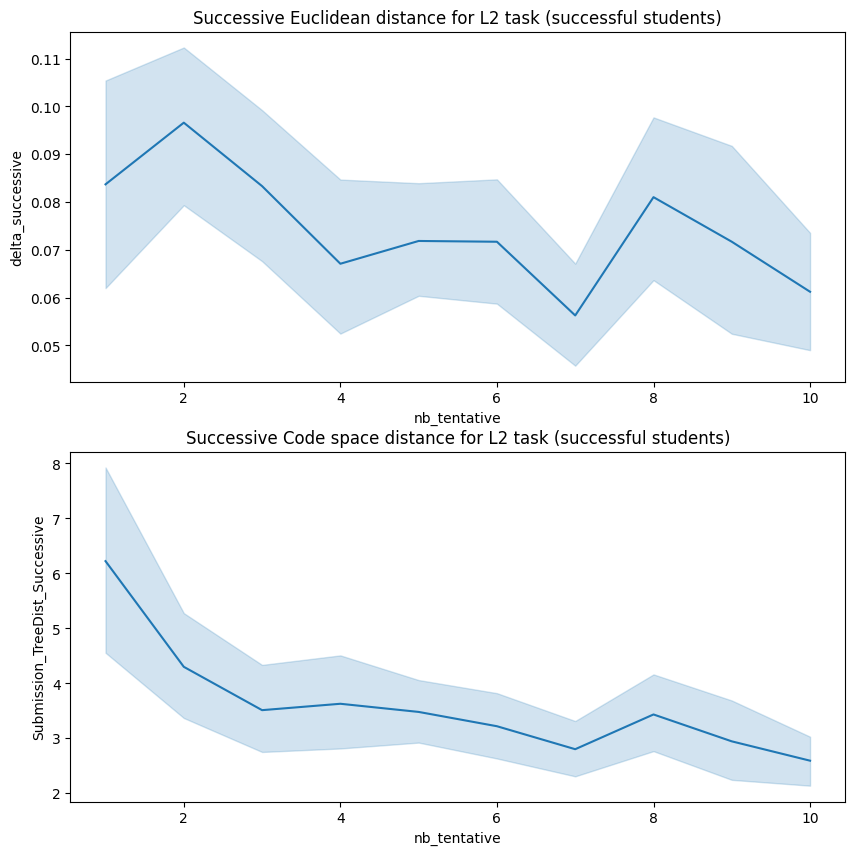

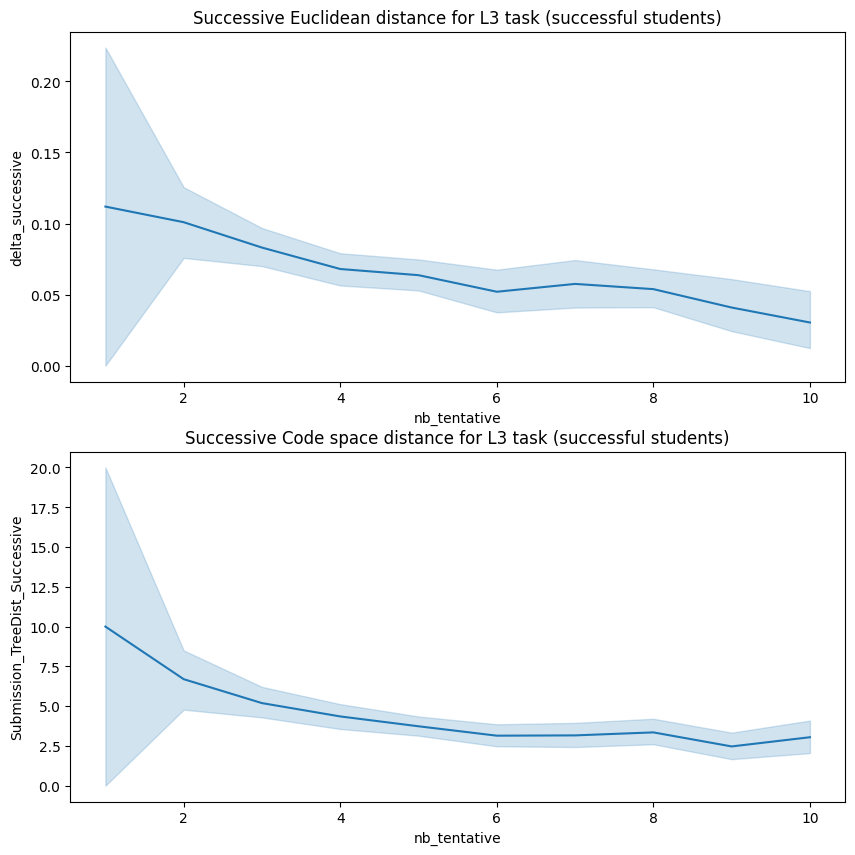

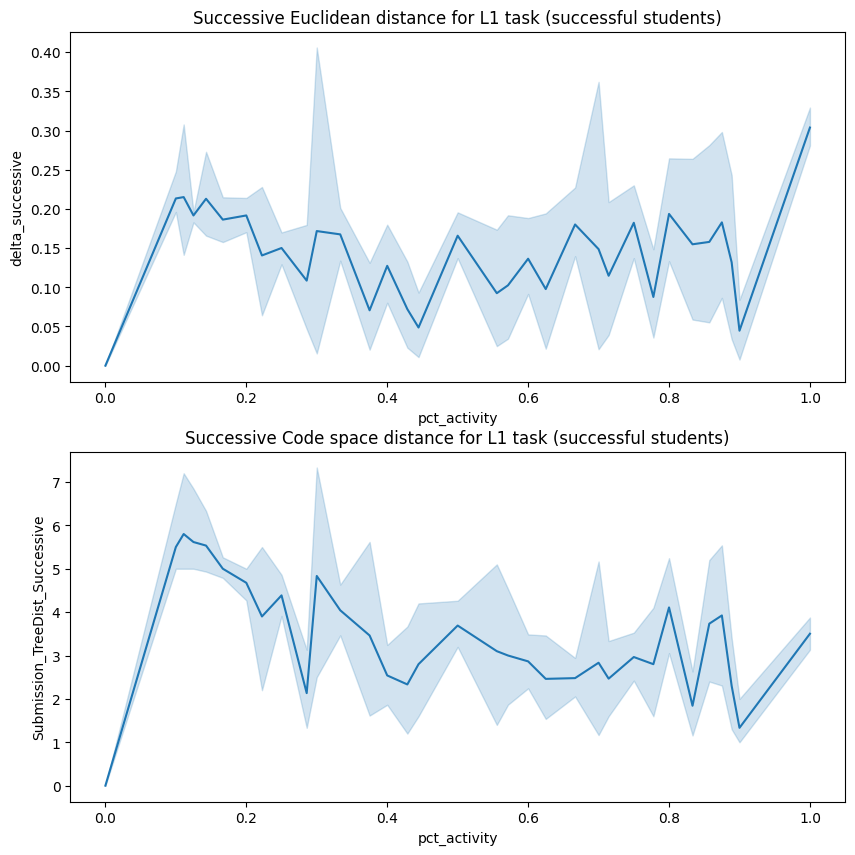

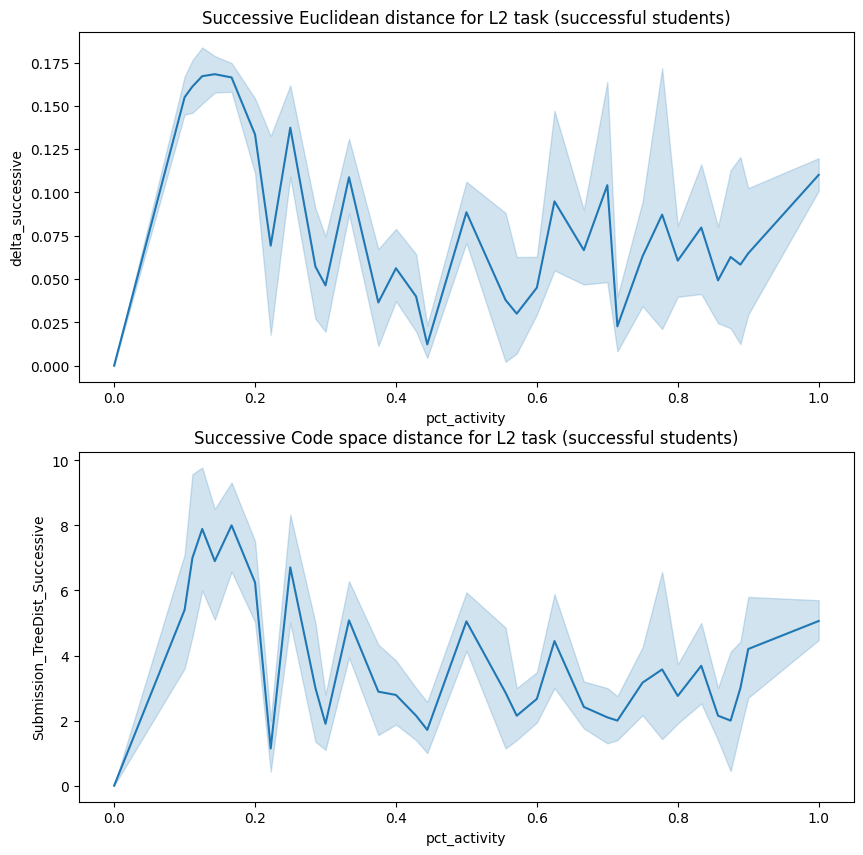

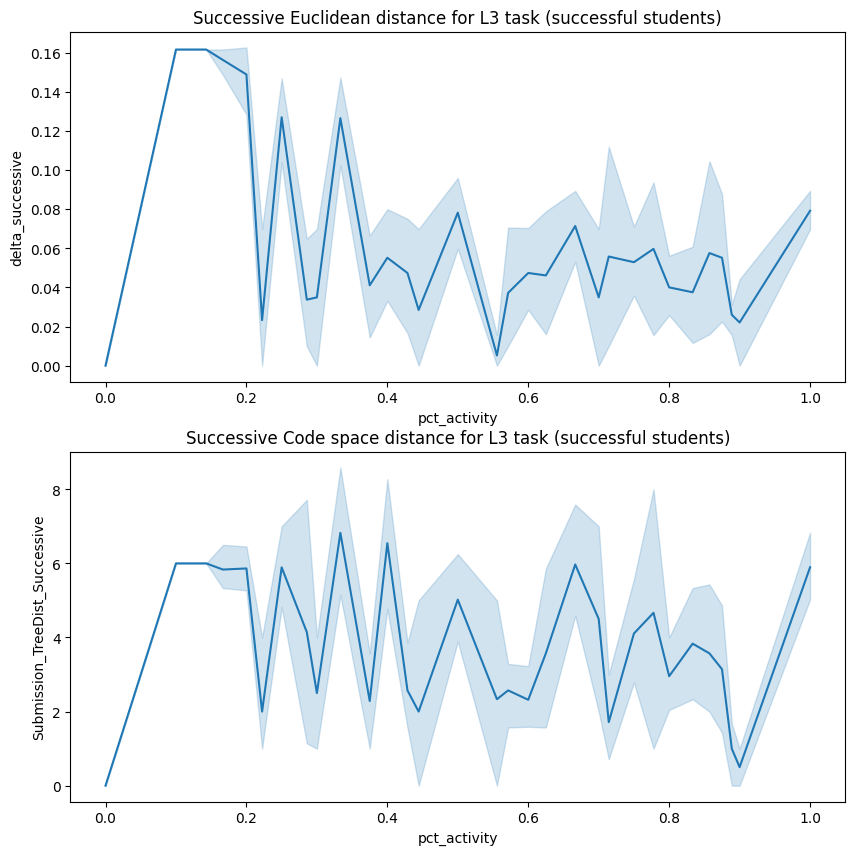

In [105]:
# plot euclidean distance and Submission_TreeDist_LastSubmission per pct_activity for successful and failing students
names = ['L1', 'L2', 'L3']
dfs = [data_l1, data_l2, data_l3]

for col in ['nb_tentative', 'pct_activity']:
    for df, name in zip(dfs, names):
        fig, axs = plt.subplots(2, 1, figsize=(10, 10))

        df_filtered = df[df['nb_tentative'] <= 10]
        df_filtered_success = df_filtered[df_filtered['success'] == 1]

        sns.lineplot(data=df_filtered_success, x=col, y='delta_successive', estimator='mean', ci=95, ax=axs[0])
        sns.lineplot(data=df_filtered_success, x=col, y='Submission_TreeDist_Successive', estimator='mean', ci=95, ax=axs[1])

        axs[0].set_title(f"Successive Euclidean distance for {name} task (successful students)")
        axs[0].set_xlabel(col)

        axs[1].set_title(f"Successive Code space distance for {name} task (successful students)")
        axs[1].set_xlabel(col)


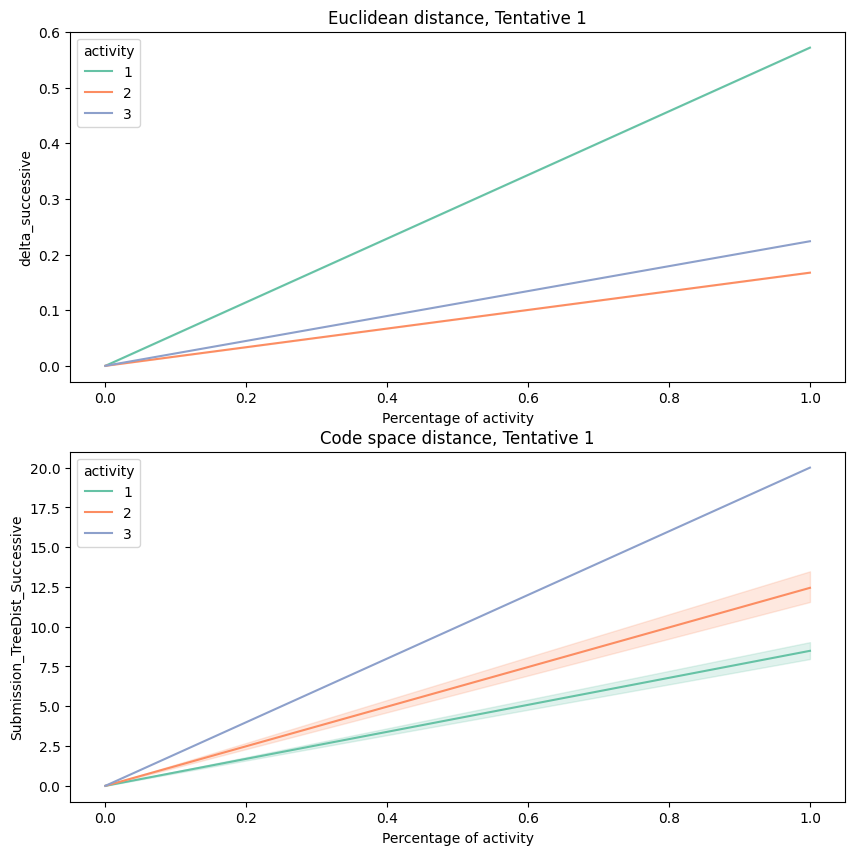

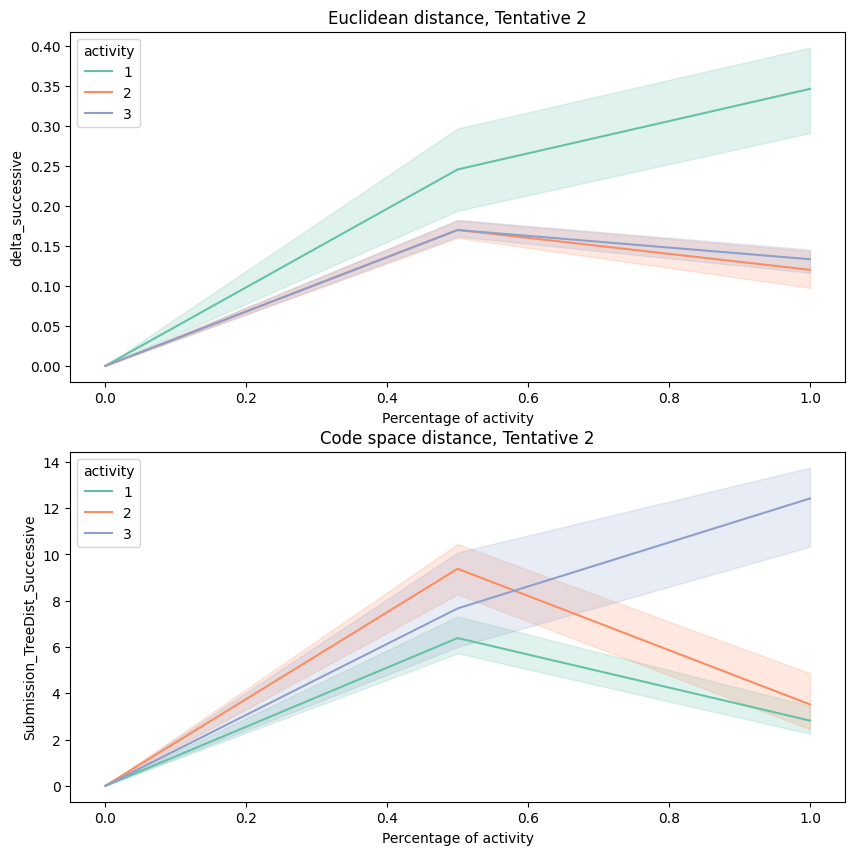

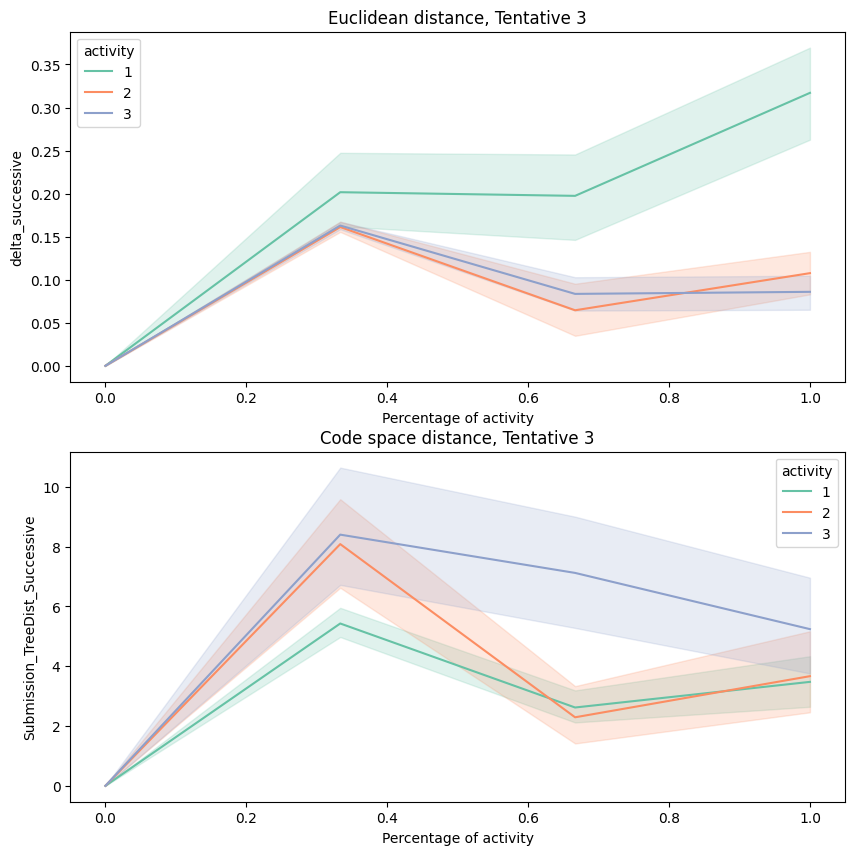

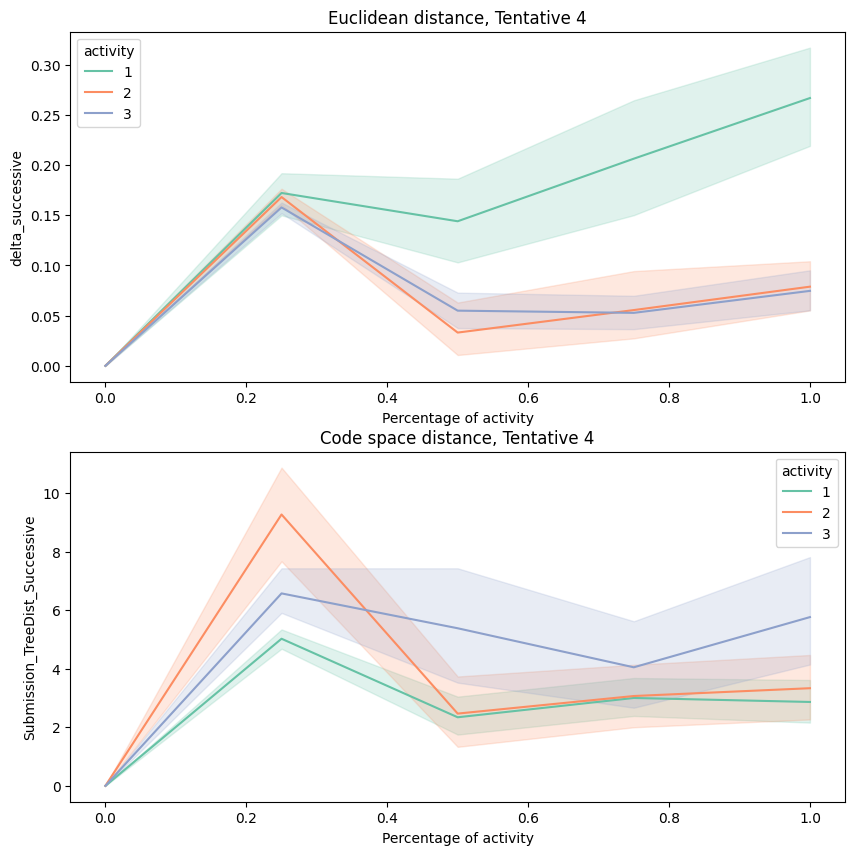

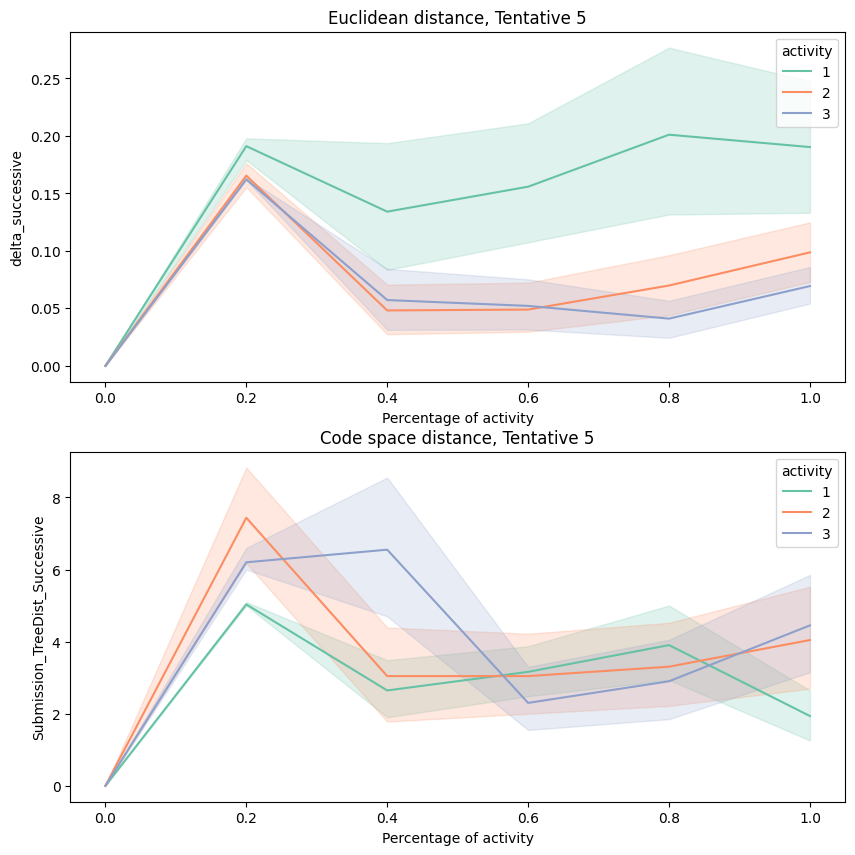

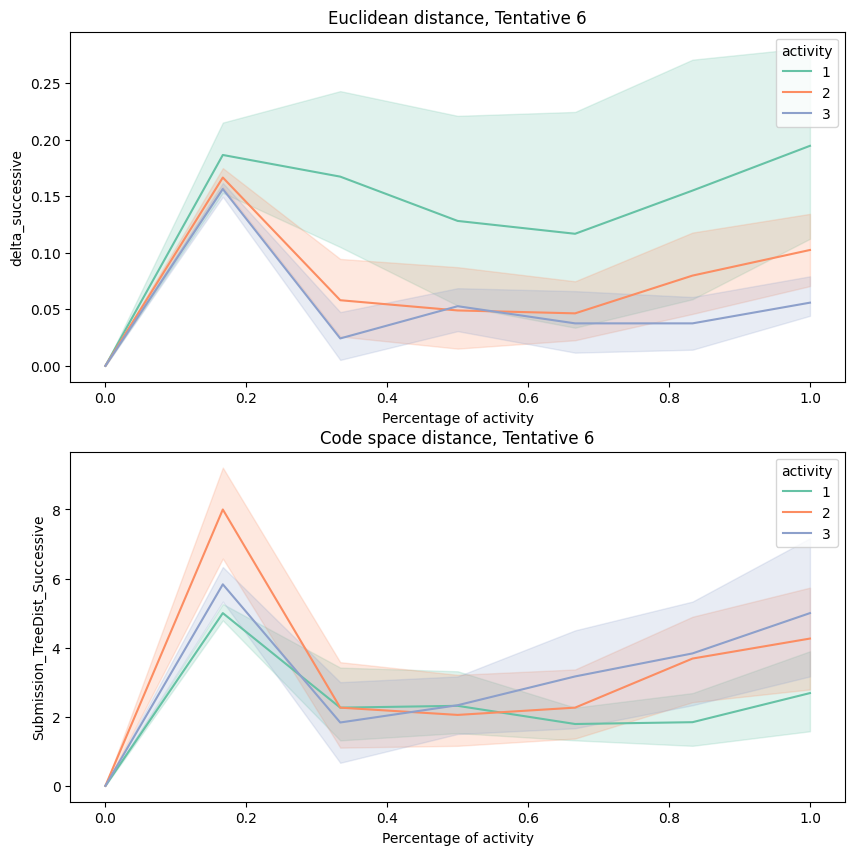

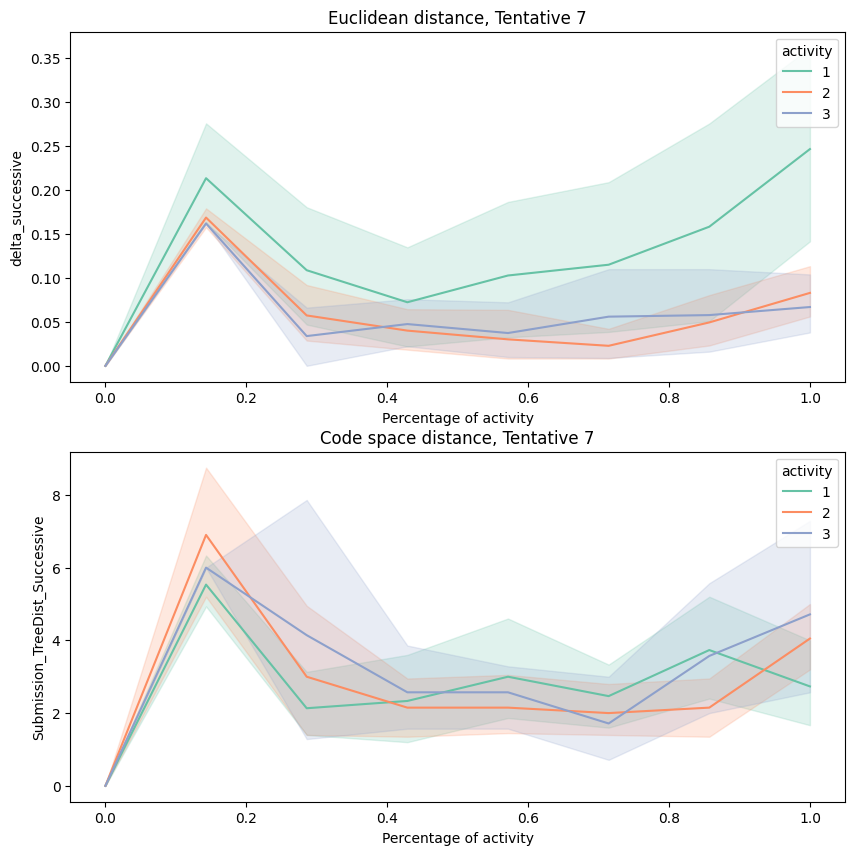

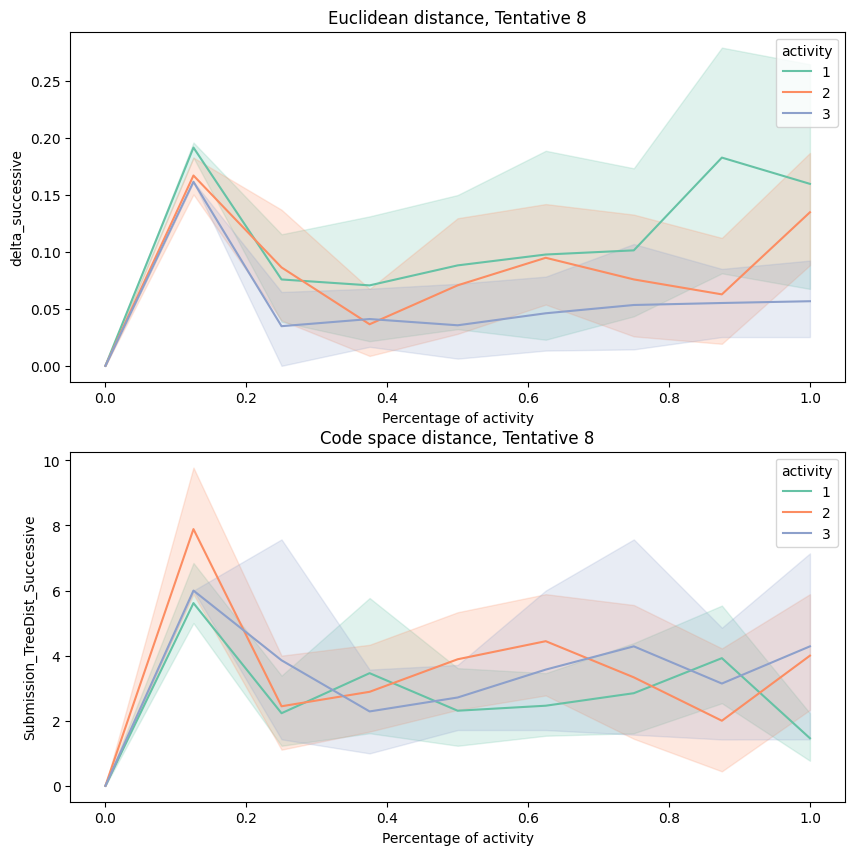

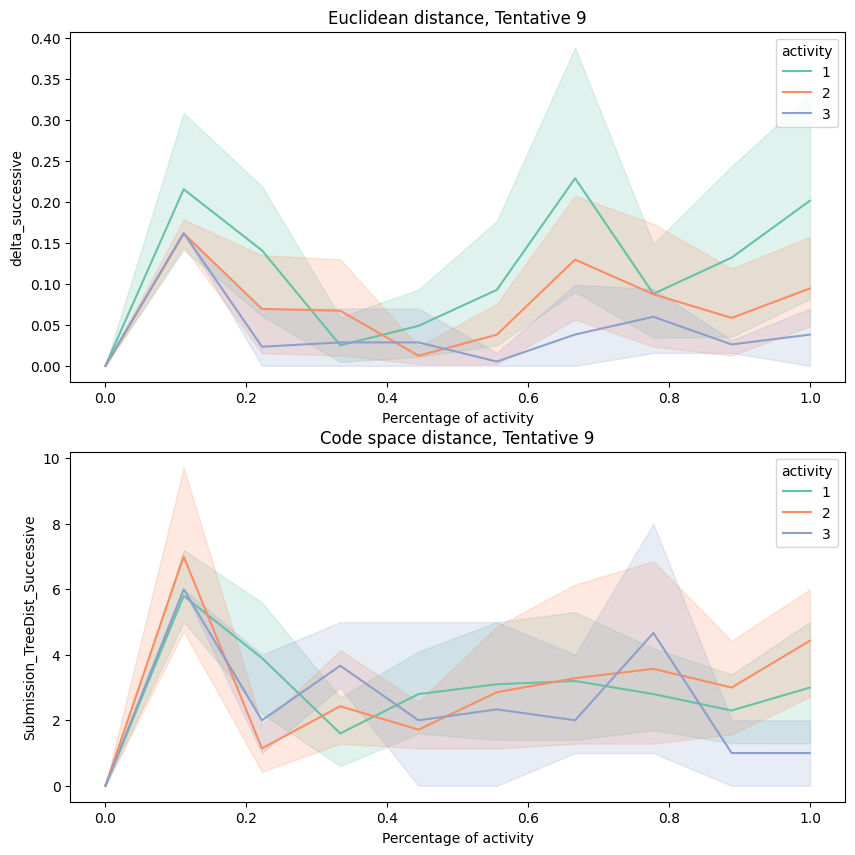

In [109]:
tentatives = [1, 2, 3, 4, 5, 6, 7, 8, 9]

for i in range(len(tentatives)):
    fig, axs = plt.subplots(2, 1, figsize=(10, 10))

    data_filtered = data[data['nb_tentative'] <= 10]
    
    data_filtered_tentative = data_filtered[data_filtered['nb_tentative'] == tentatives[i]]
    data_success_tentative = data_filtered_tentative[data_filtered_tentative['success'] == 1]

    sns.lineplot(data=data_success_tentative, x='pct_activity', y='delta_successive', hue='activity', estimator='mean', ci=95, ax=axs[0], palette='Set2')
    sns.lineplot(data=data_success_tentative, x='pct_activity', y='Submission_TreeDist_Successive', hue='activity', estimator='mean', ci=95, ax=axs[1], palette='Set2')

    axs[0].set_title(f"Euclidean distance, Tentative {tentatives[i]}")
    axs[0].set_xlabel("Percentage of activity")

    axs[1].set_title(f"Code space distance, Tentative {tentatives[i]}")
    axs[1].set_xlabel("Percentage of activity")
    
    plt.show()

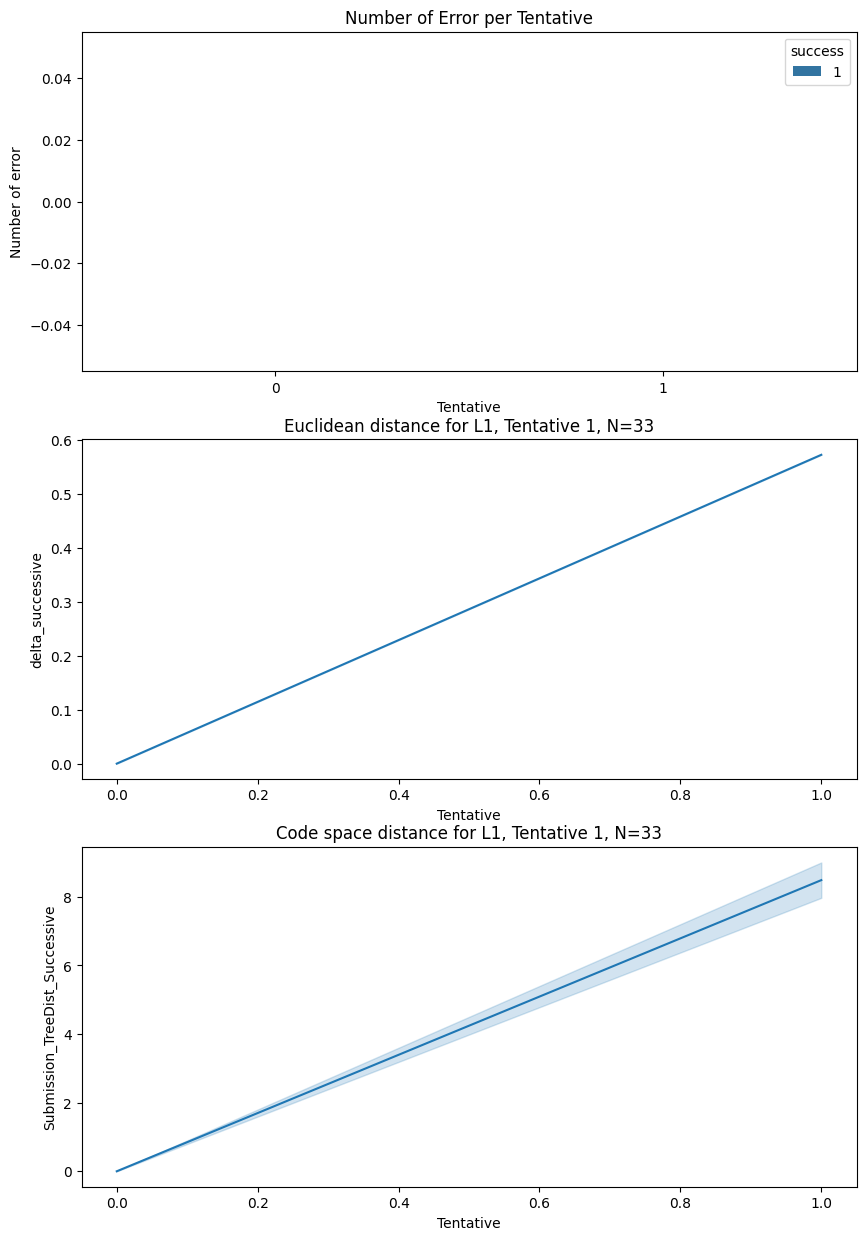

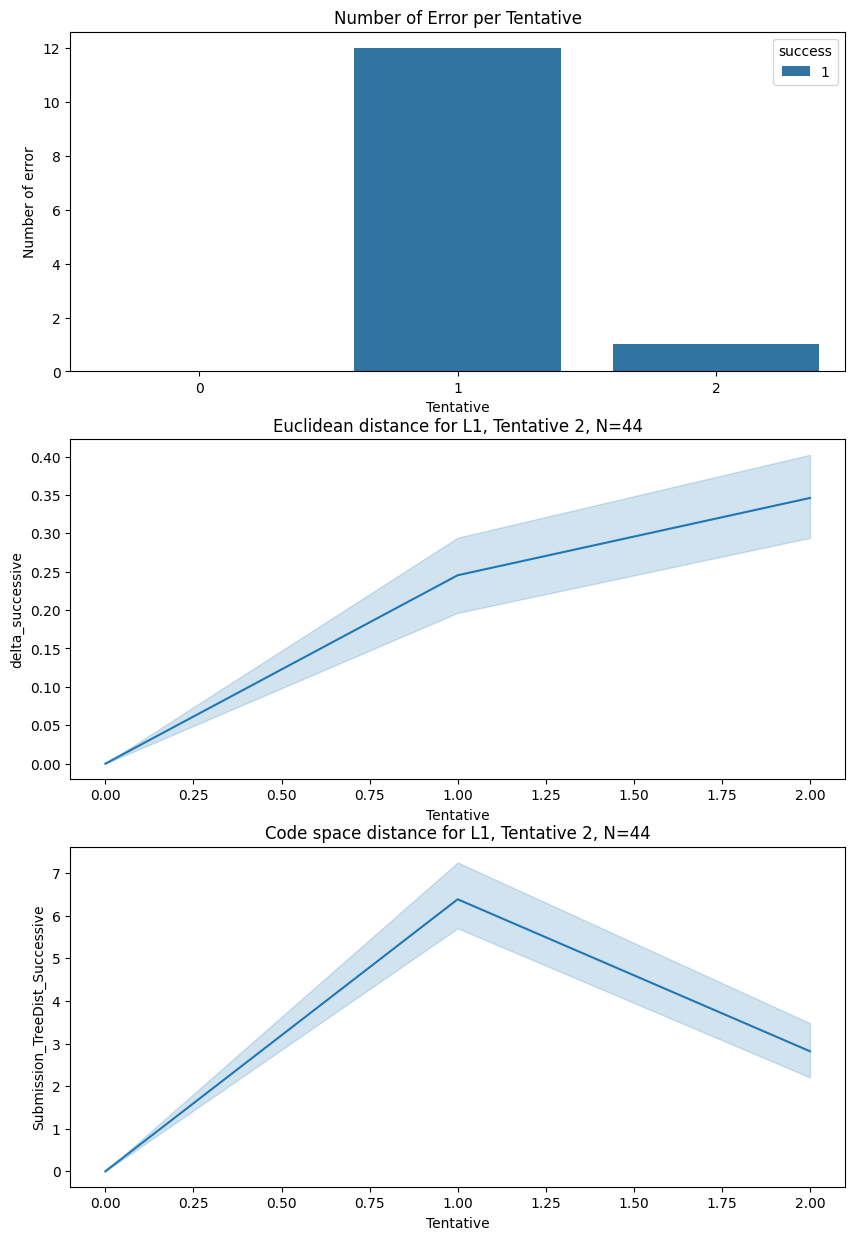

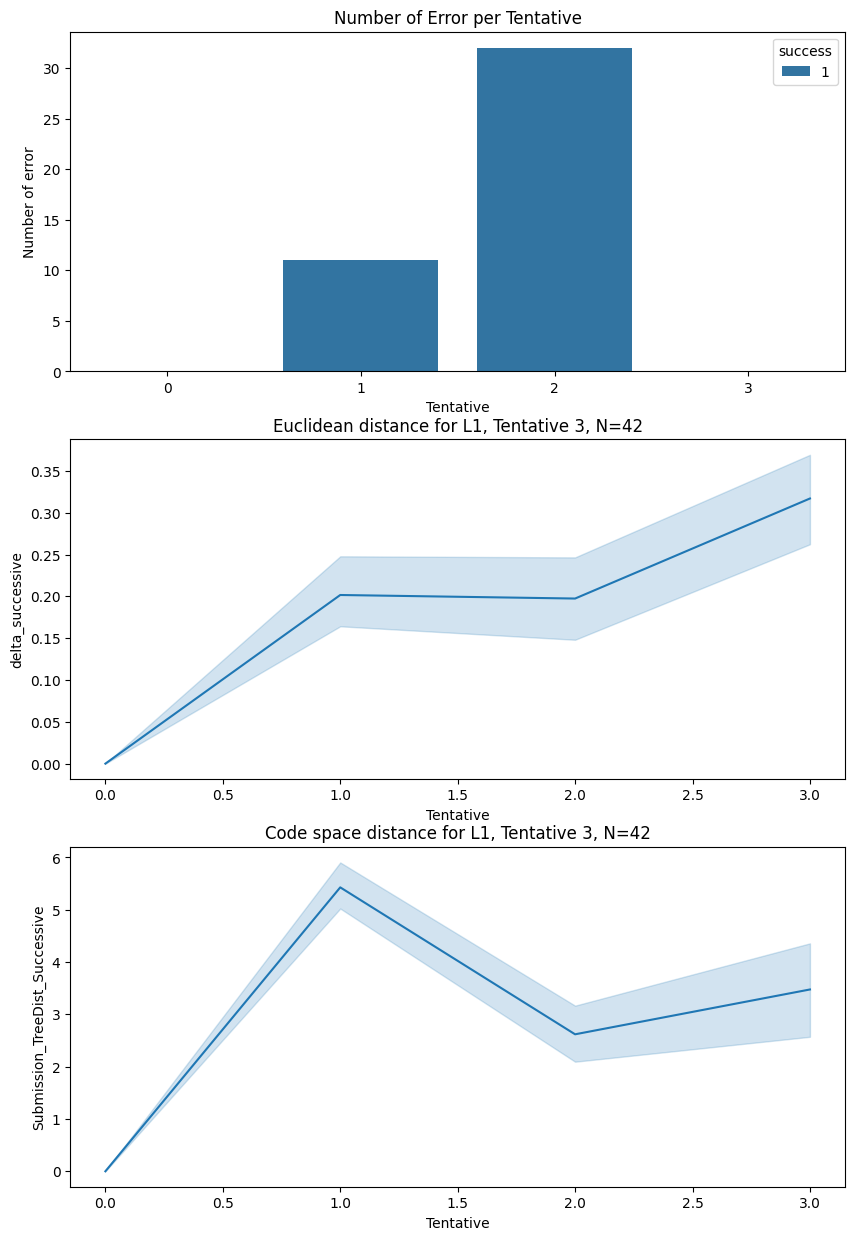

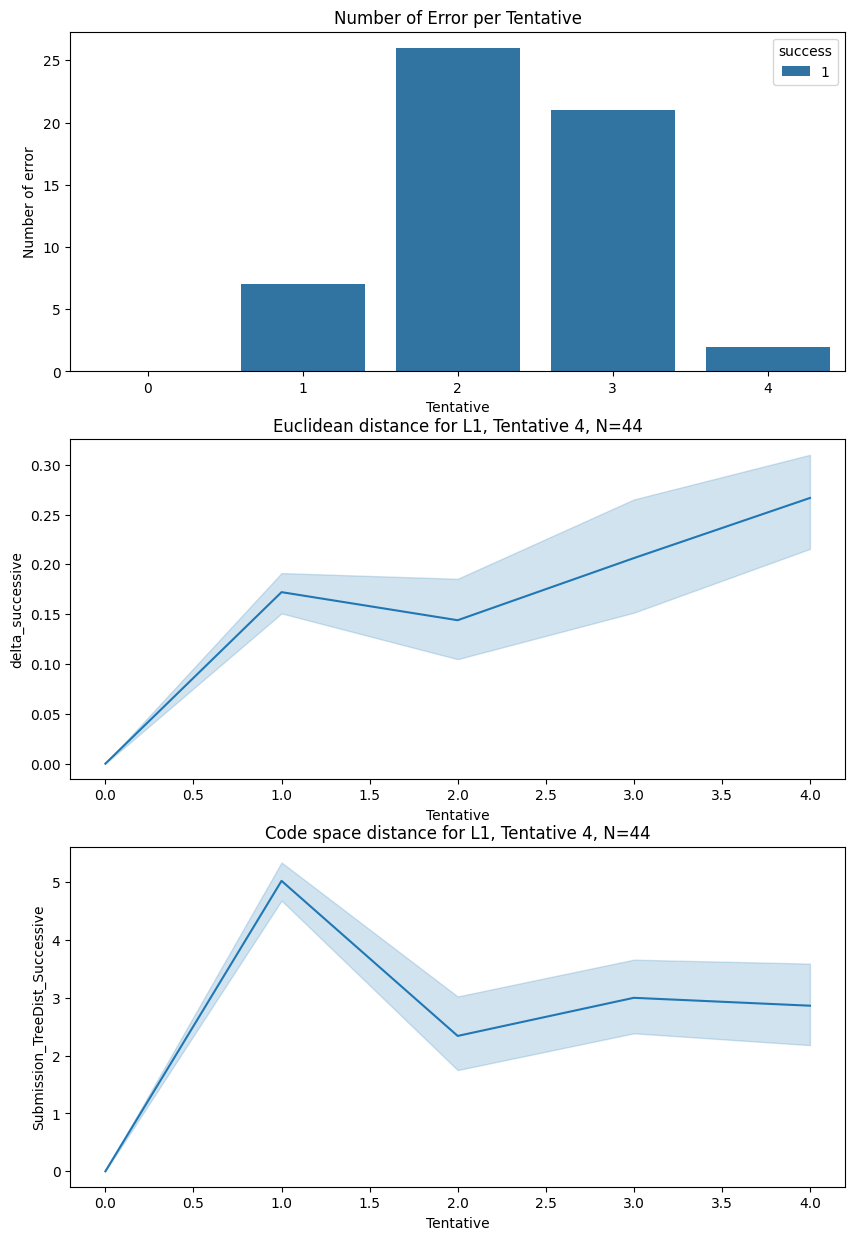

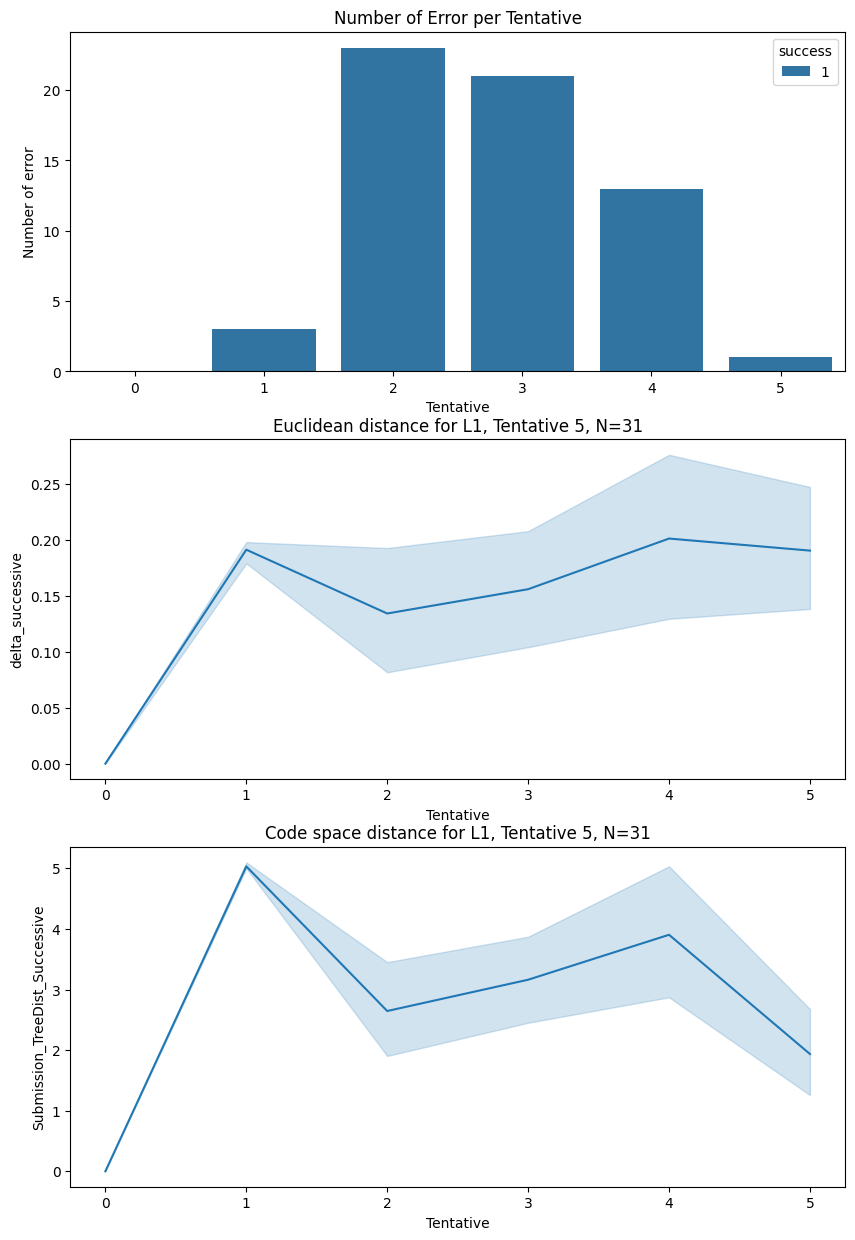

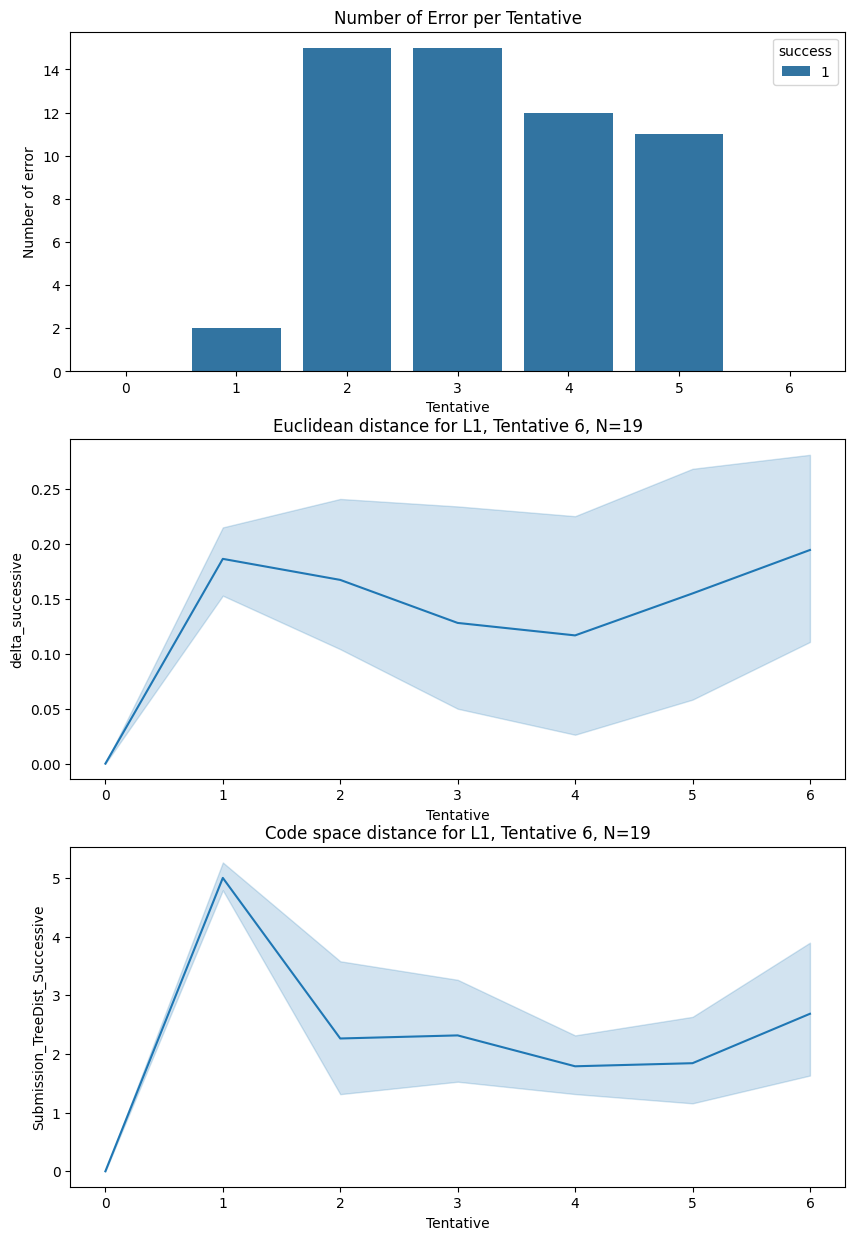

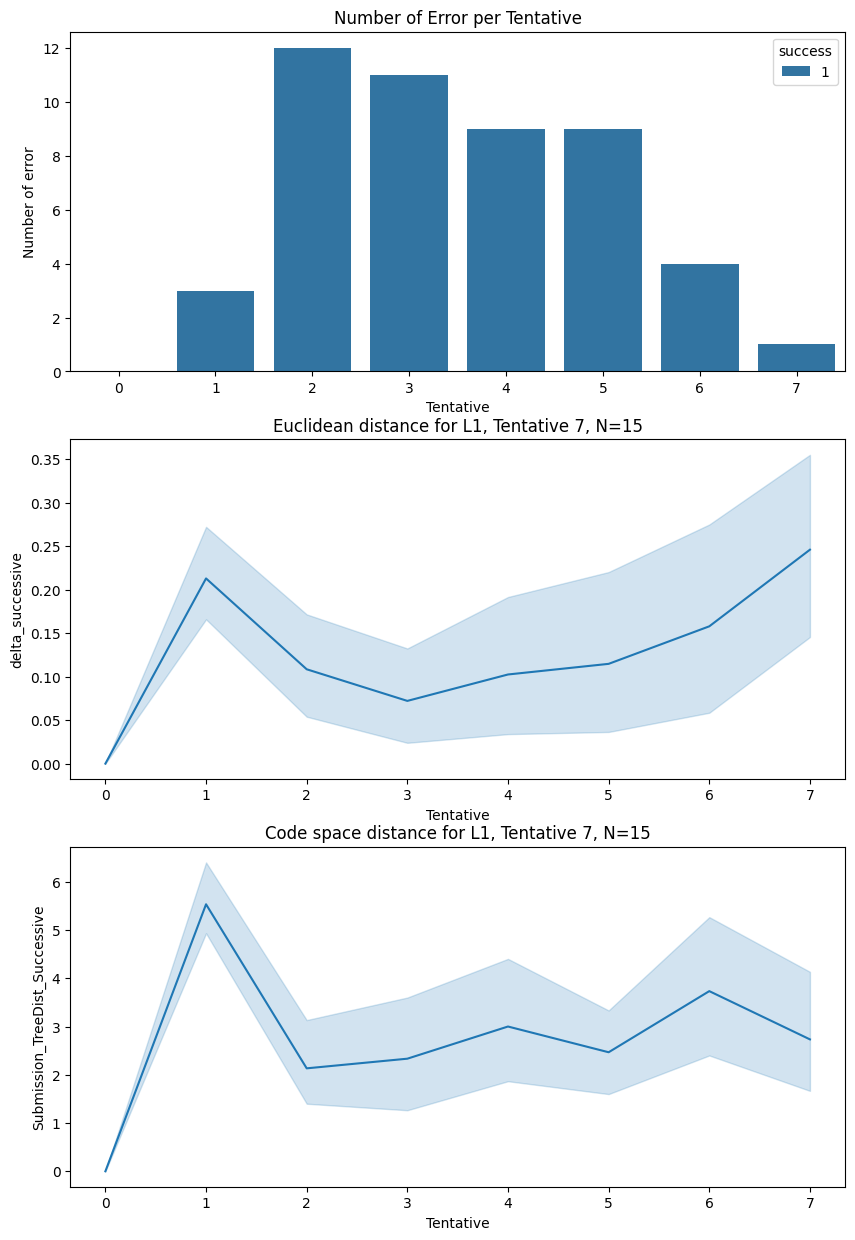

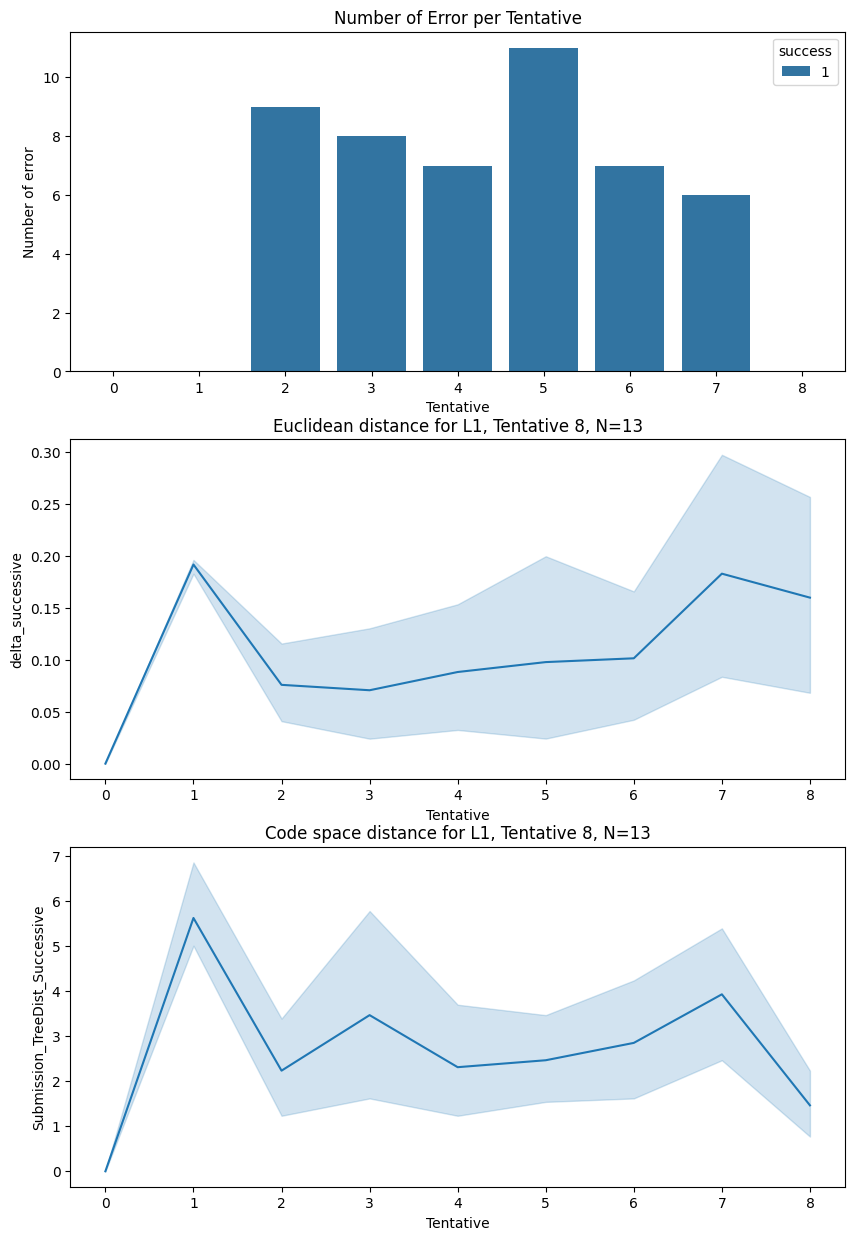

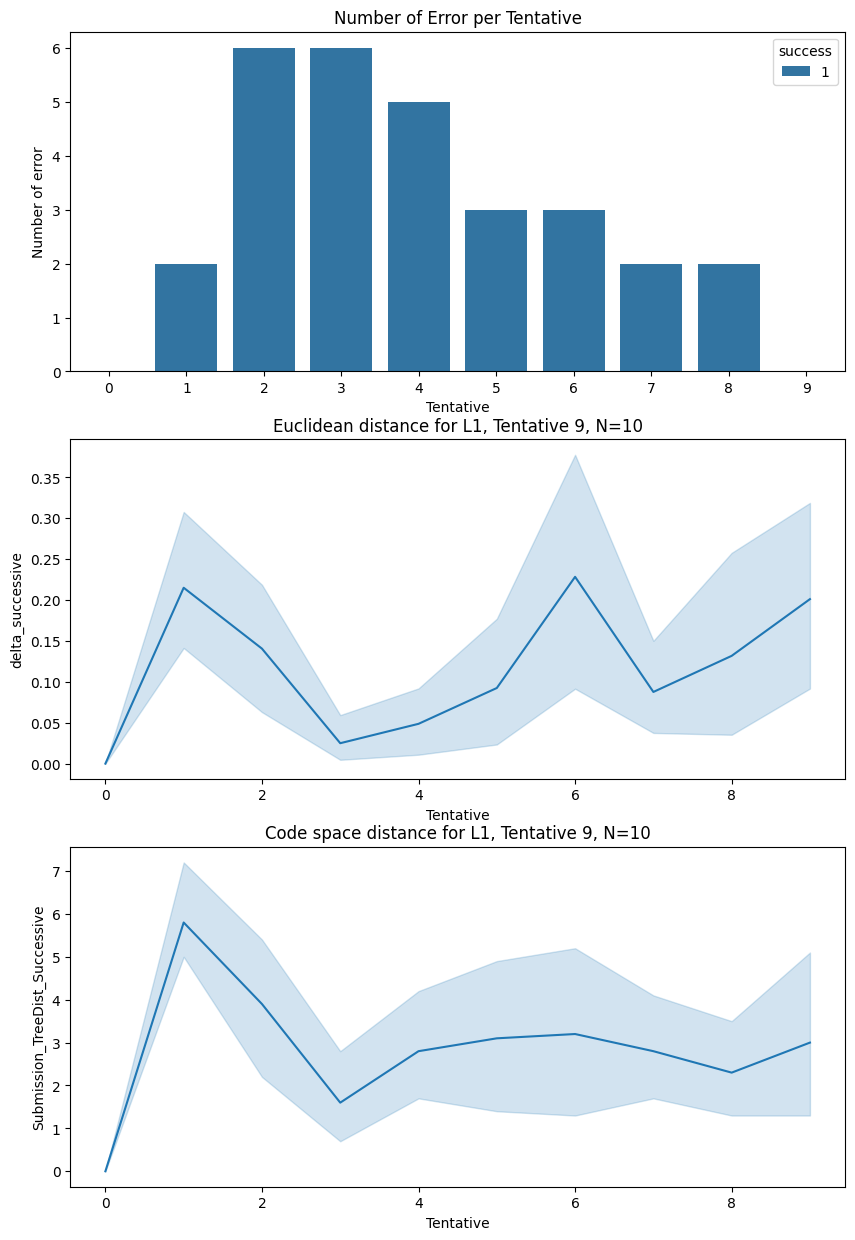

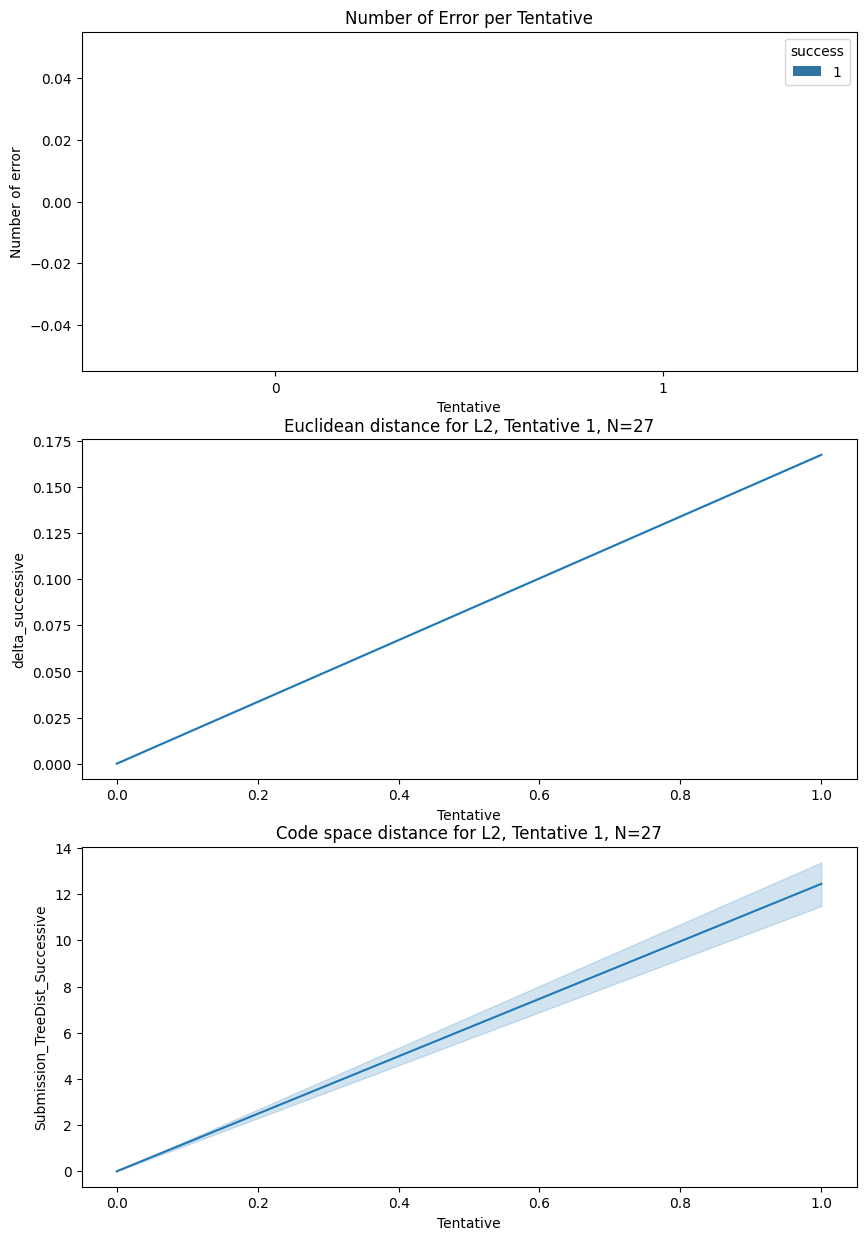

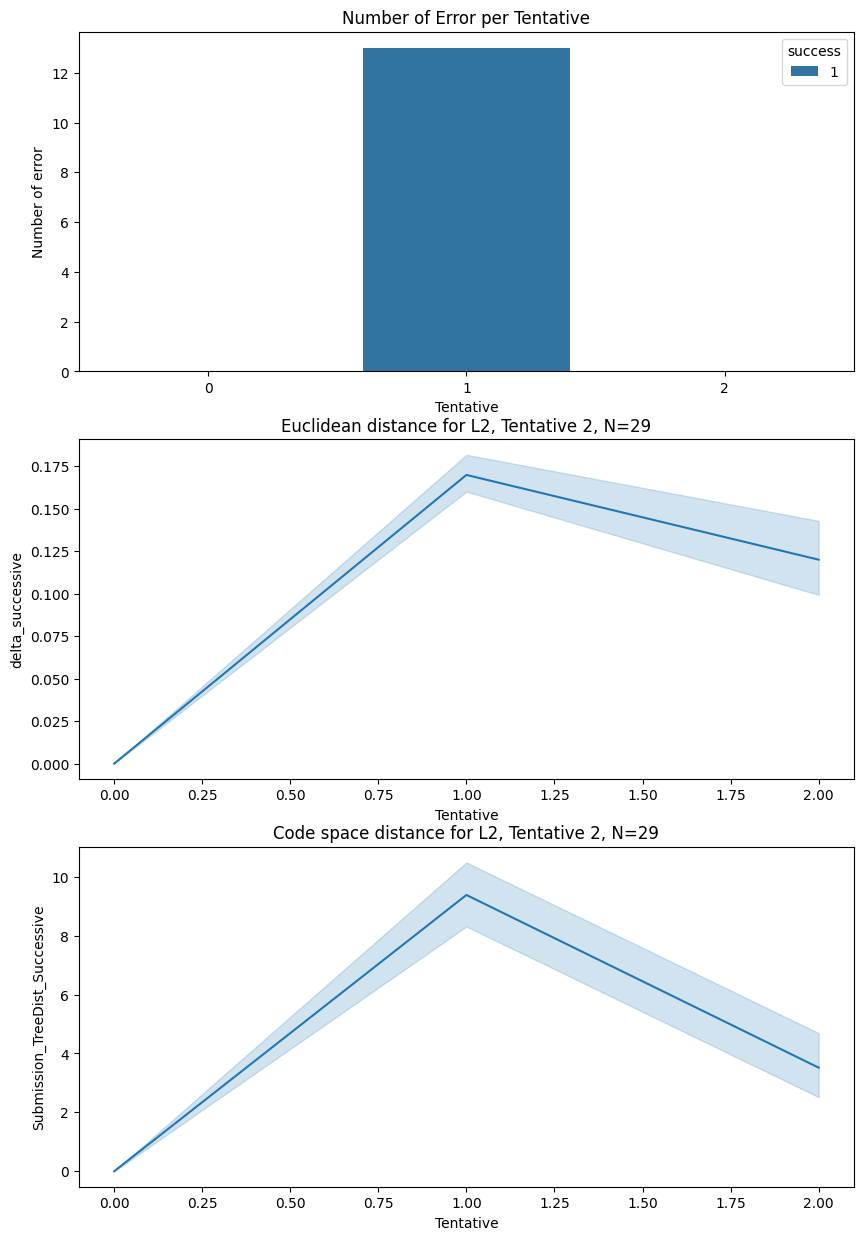

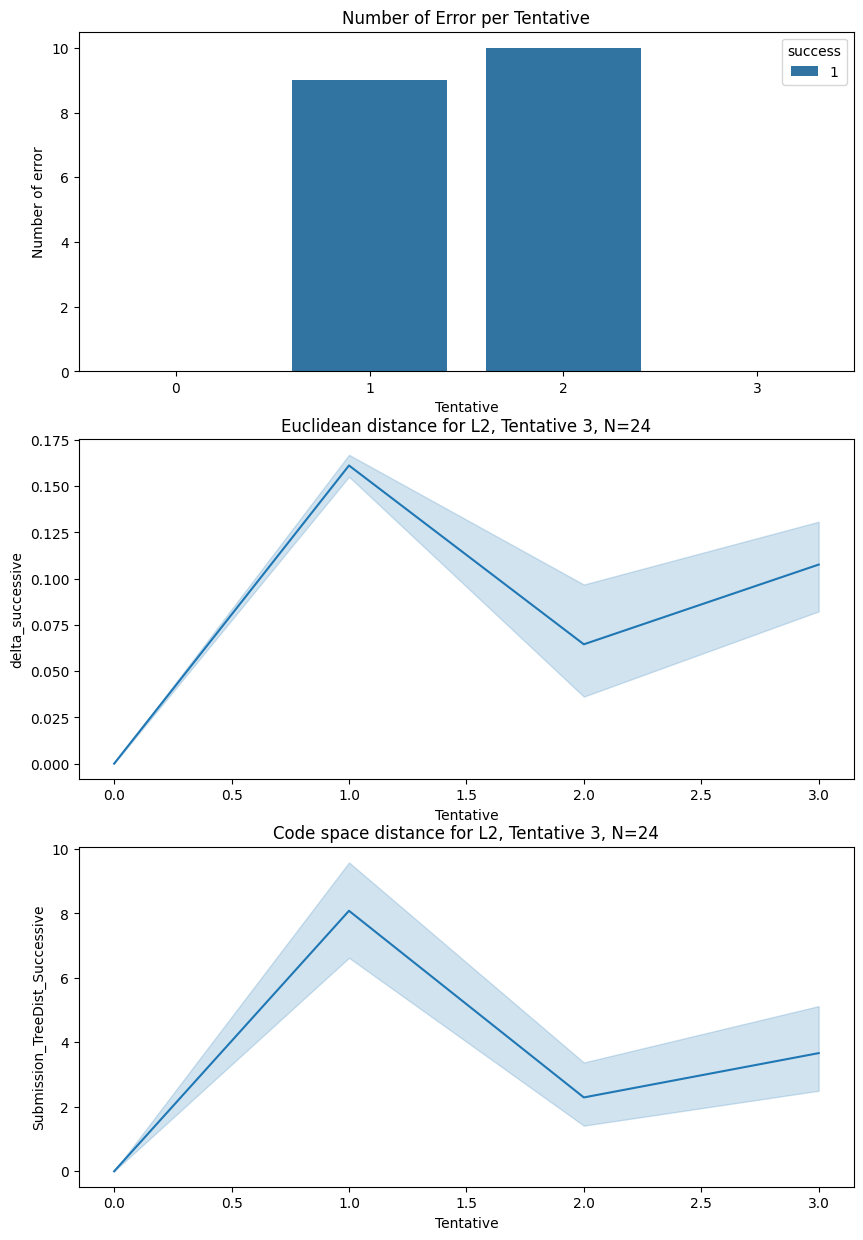

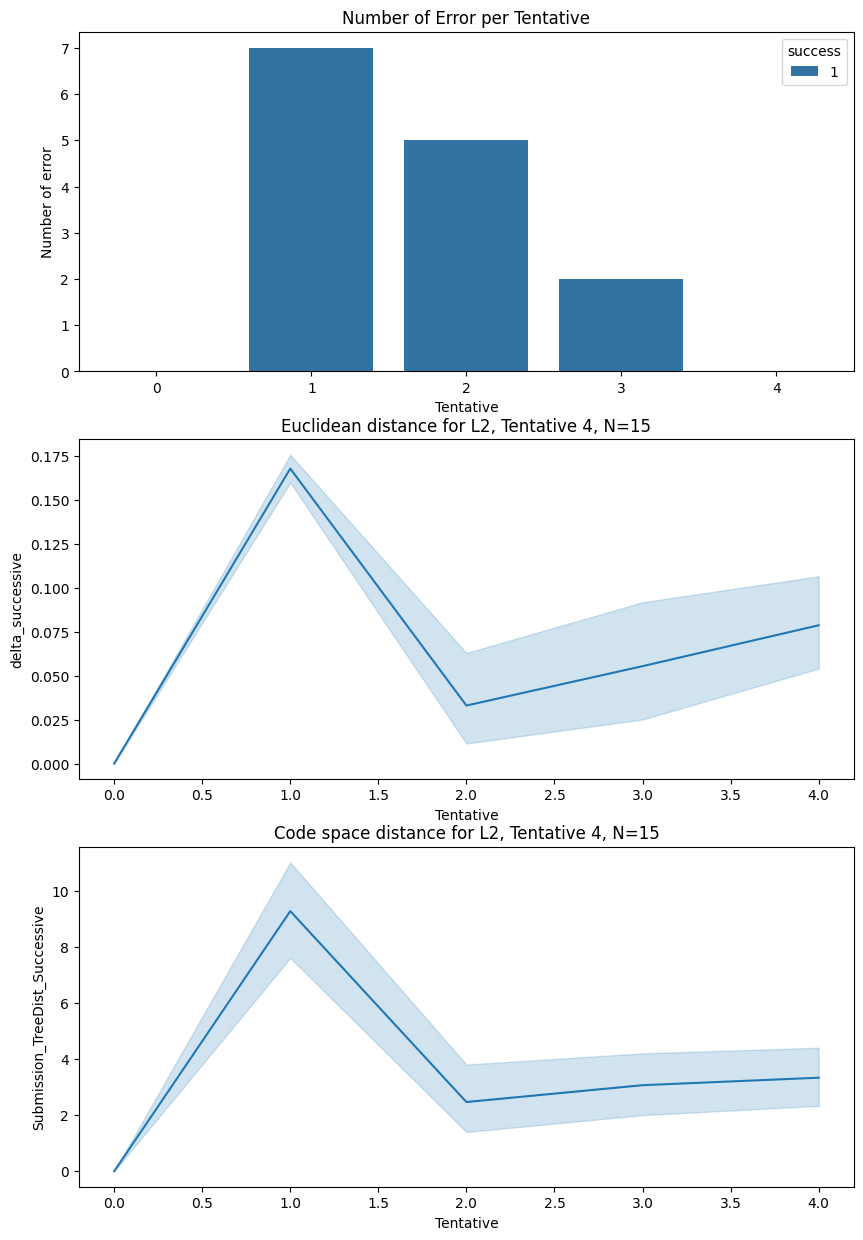

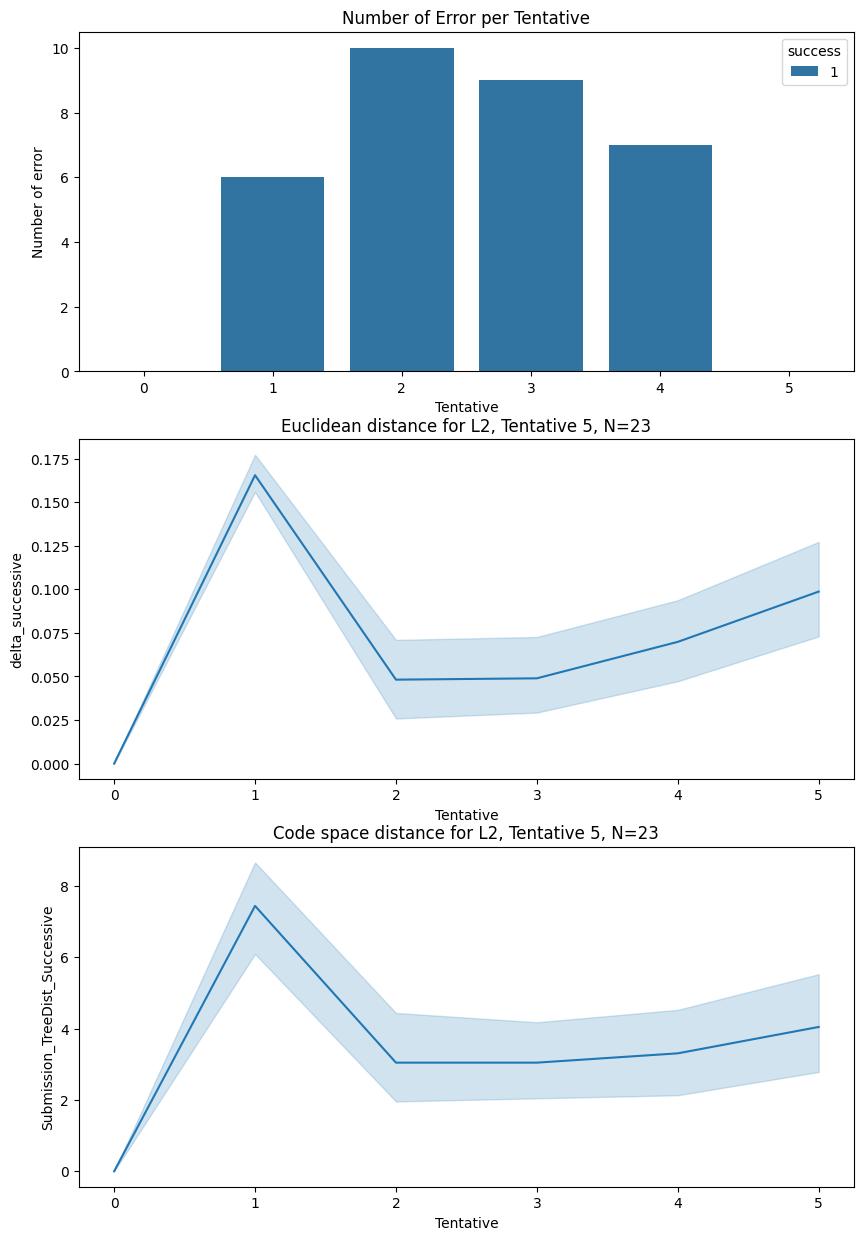

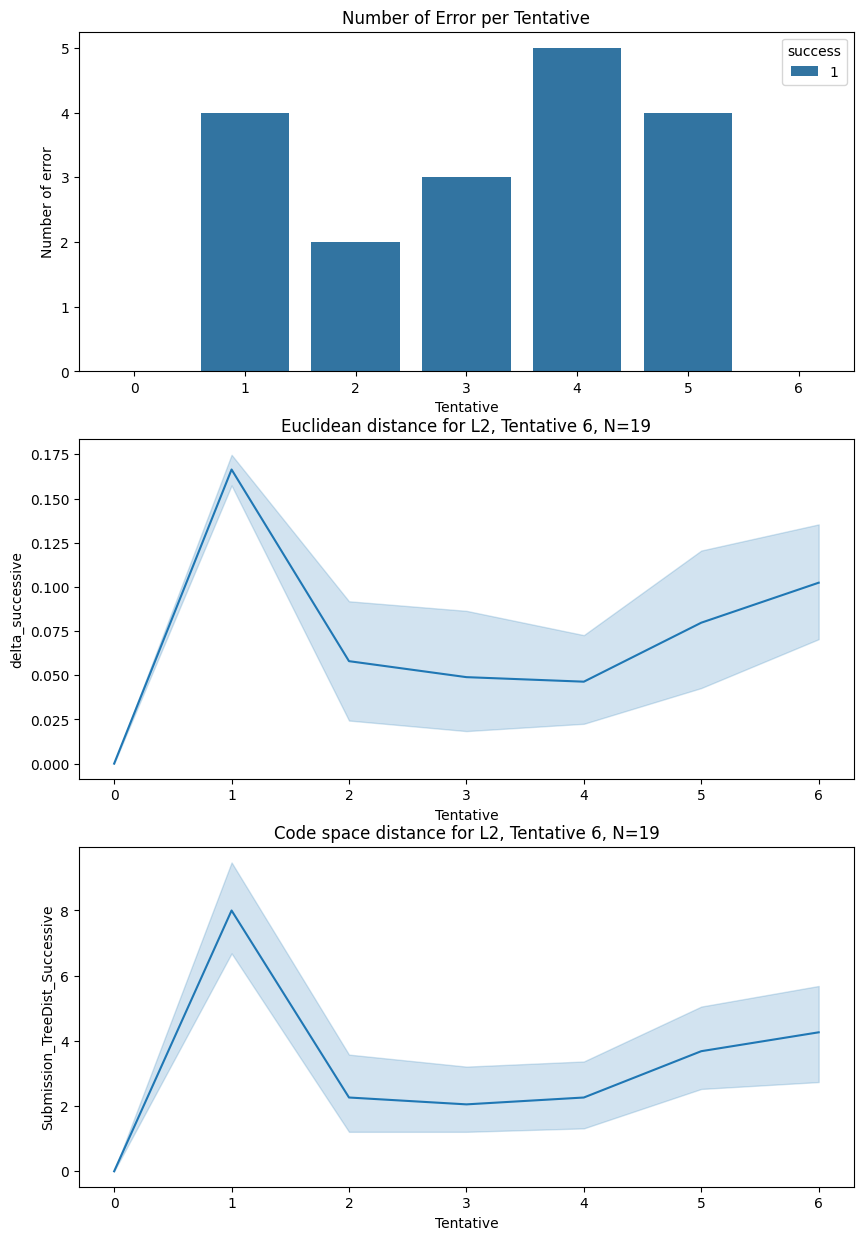

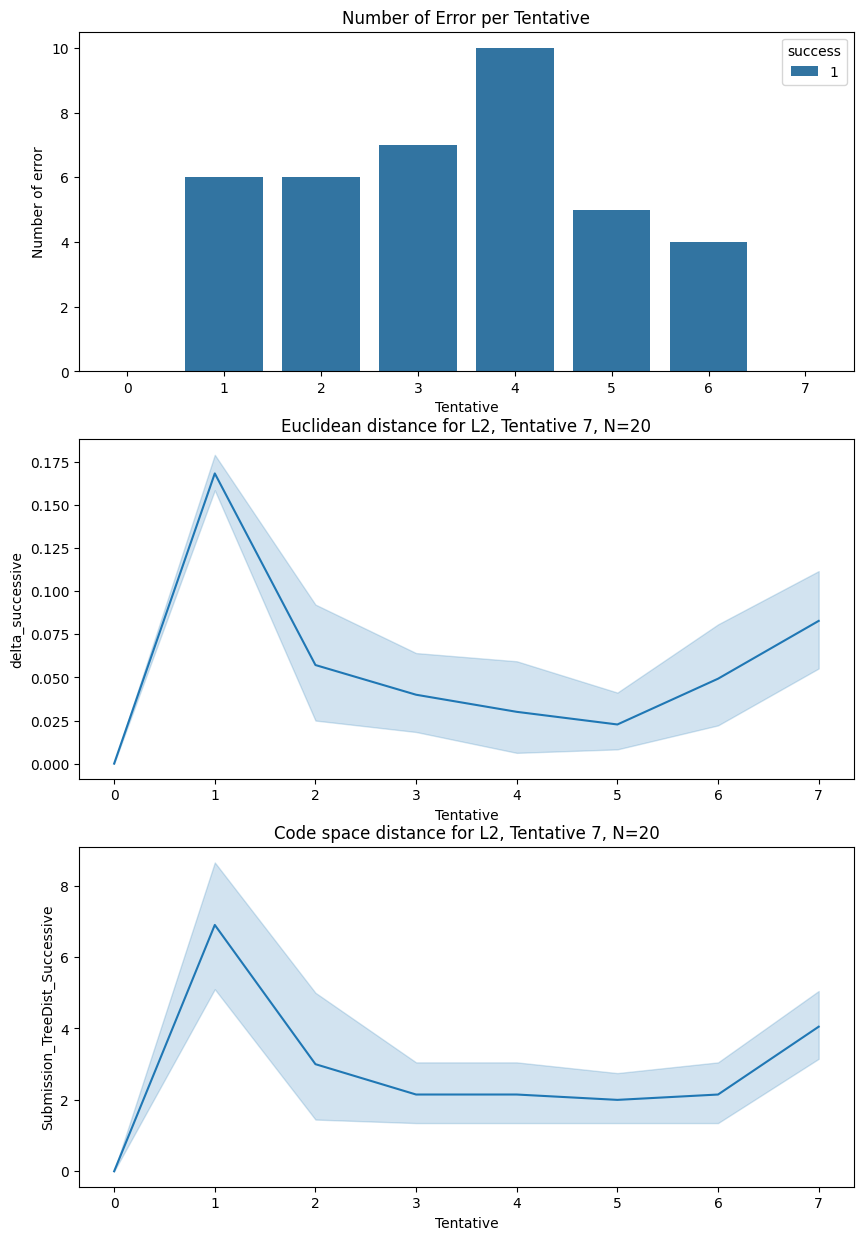

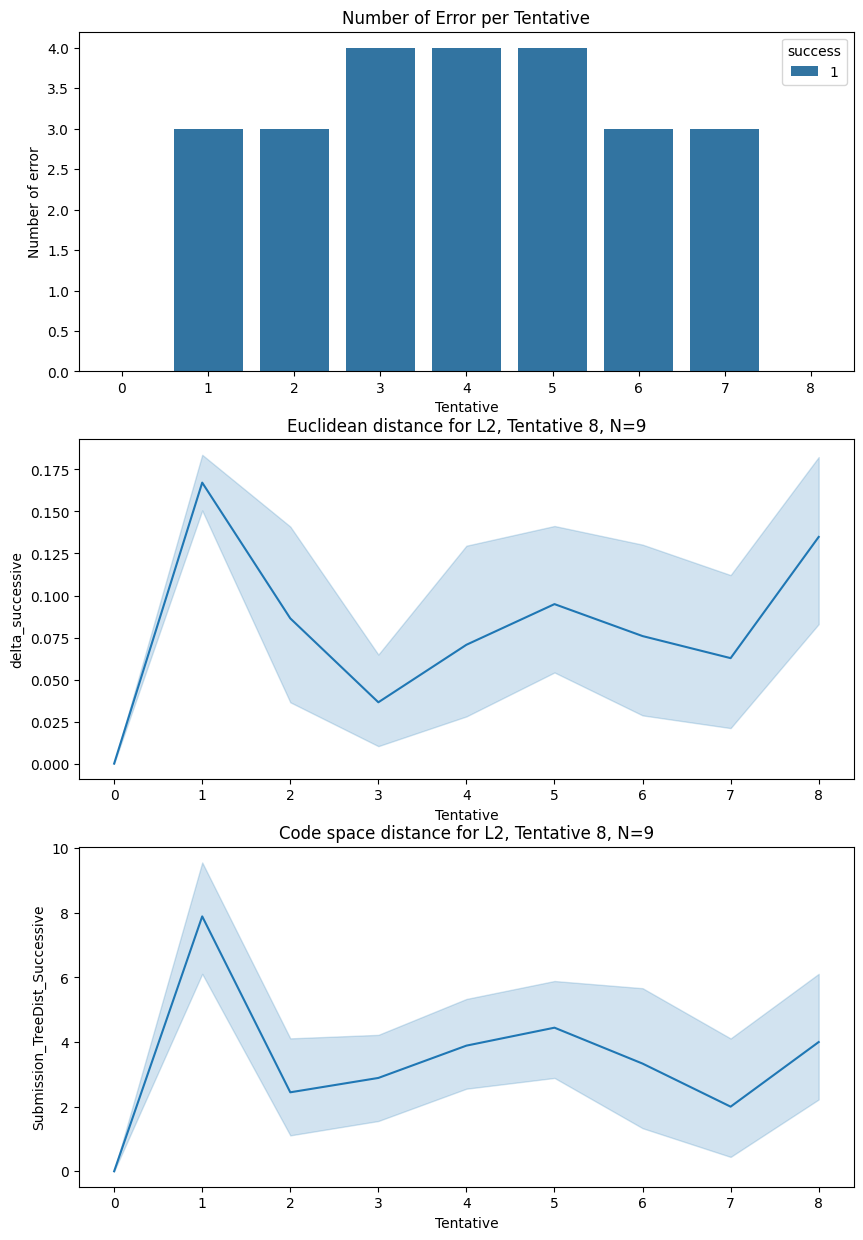

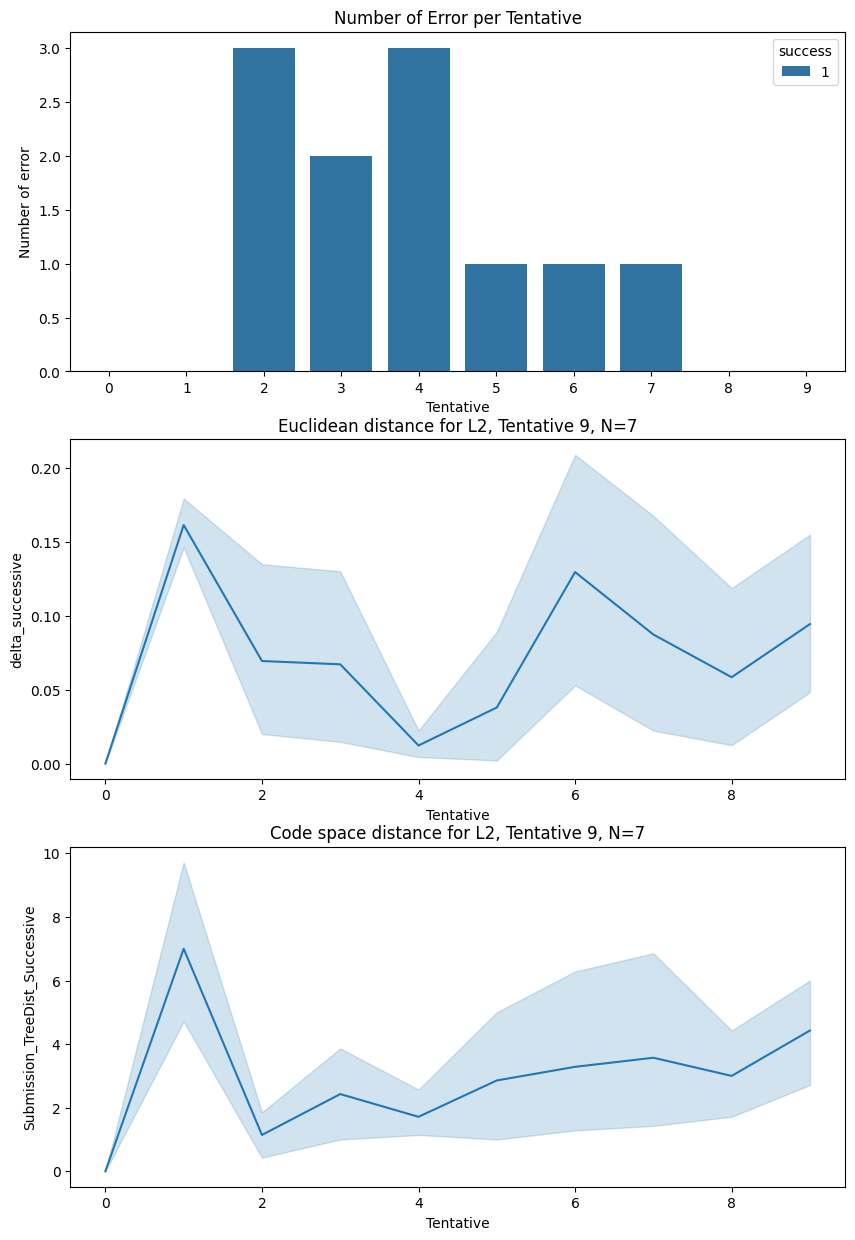

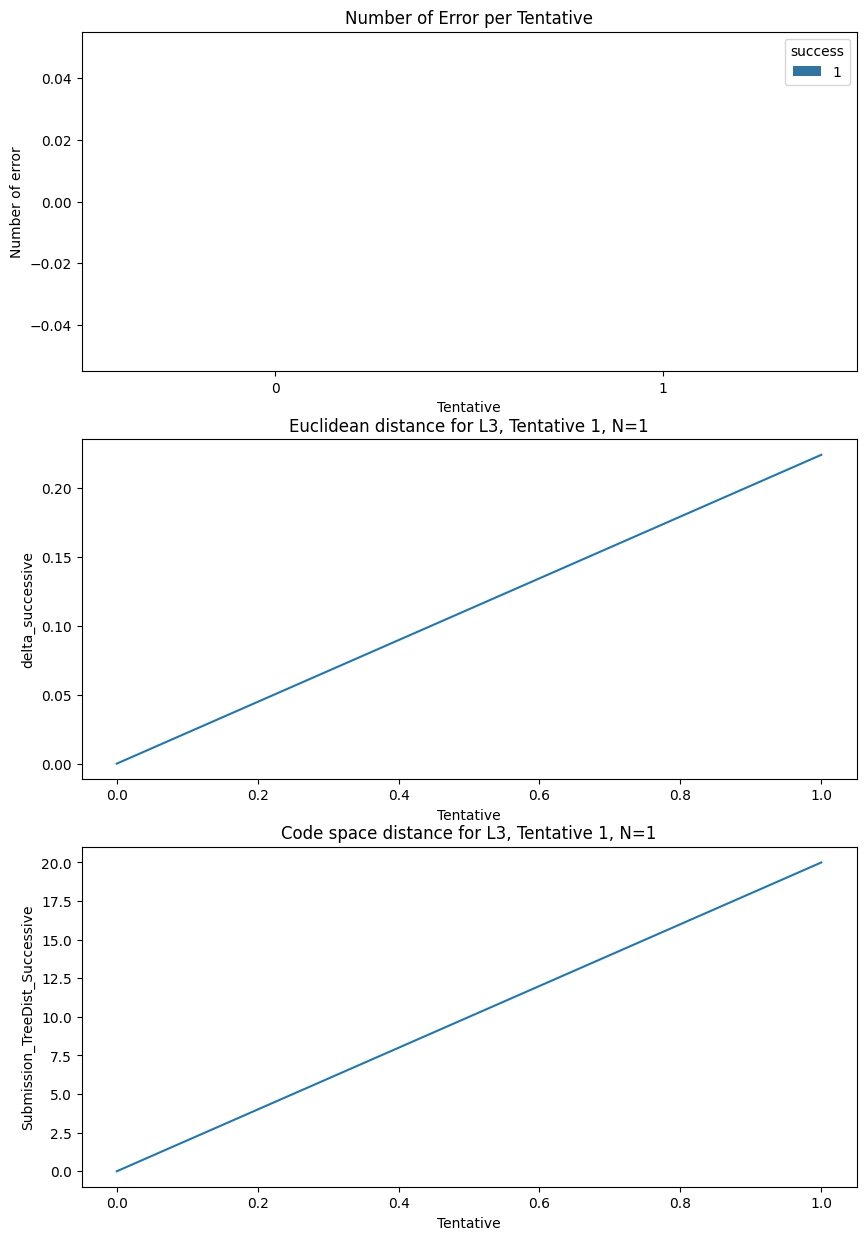

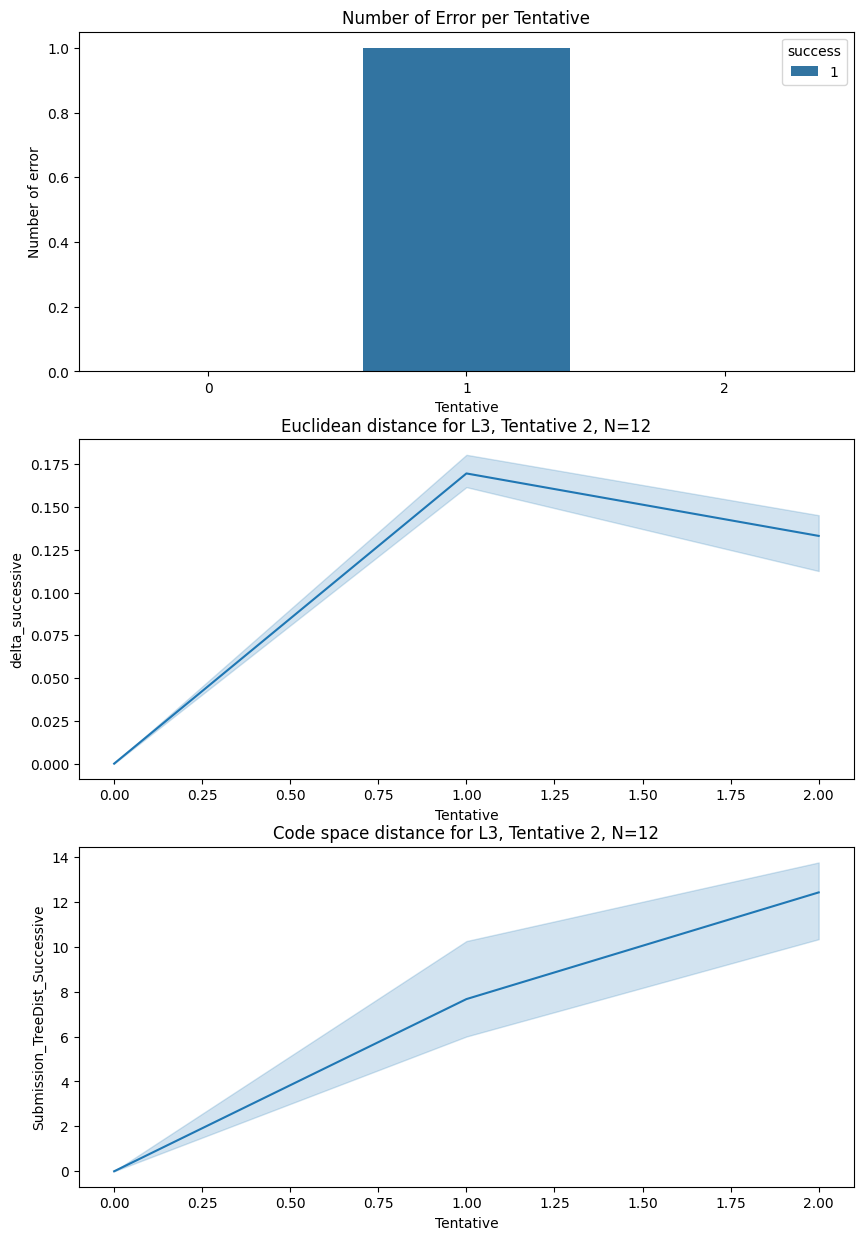

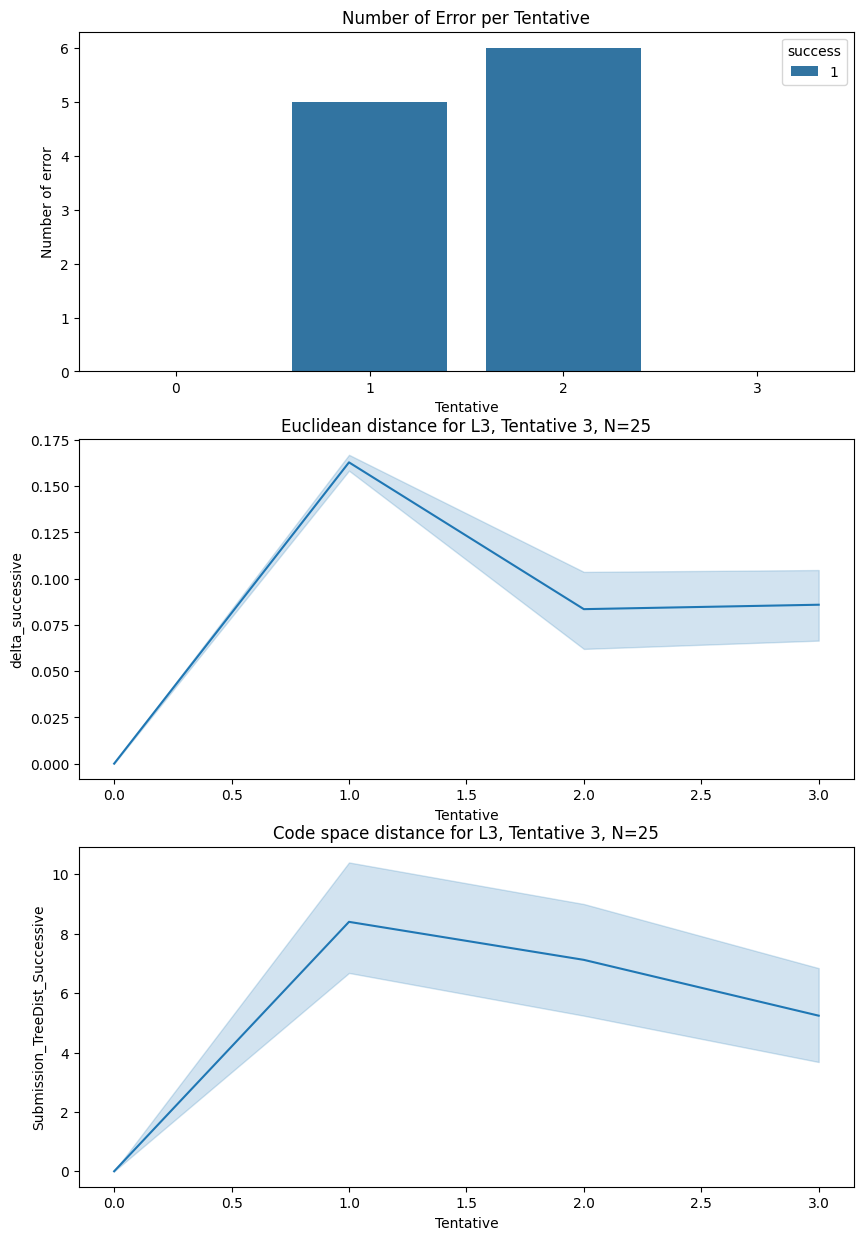

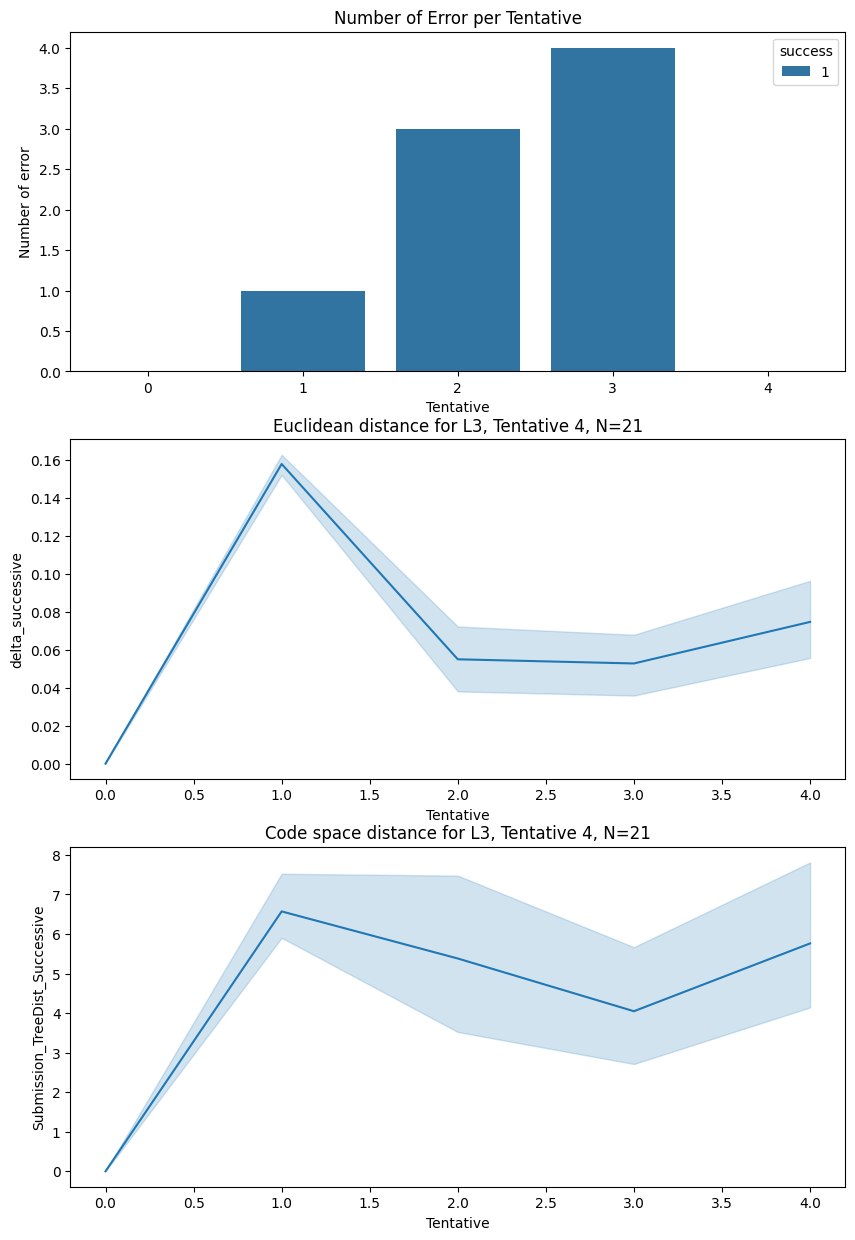

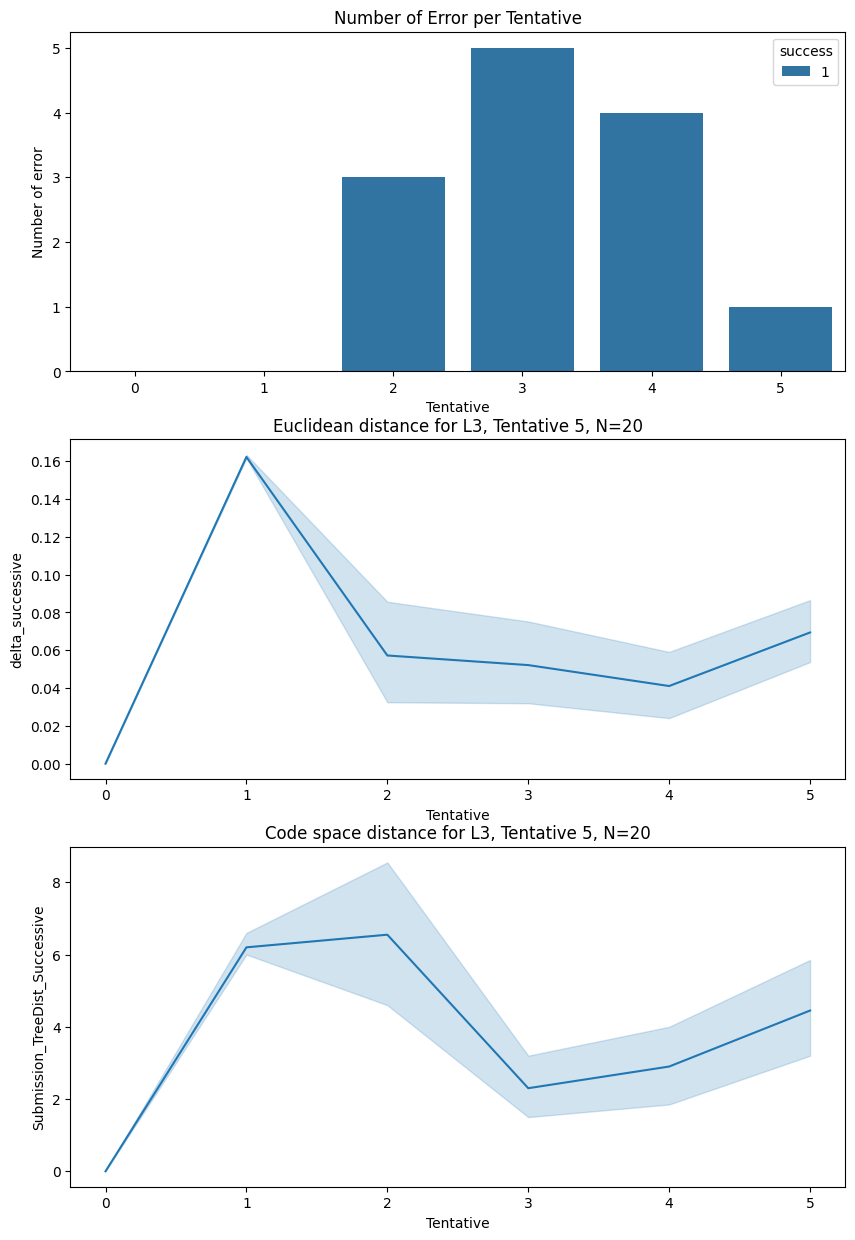

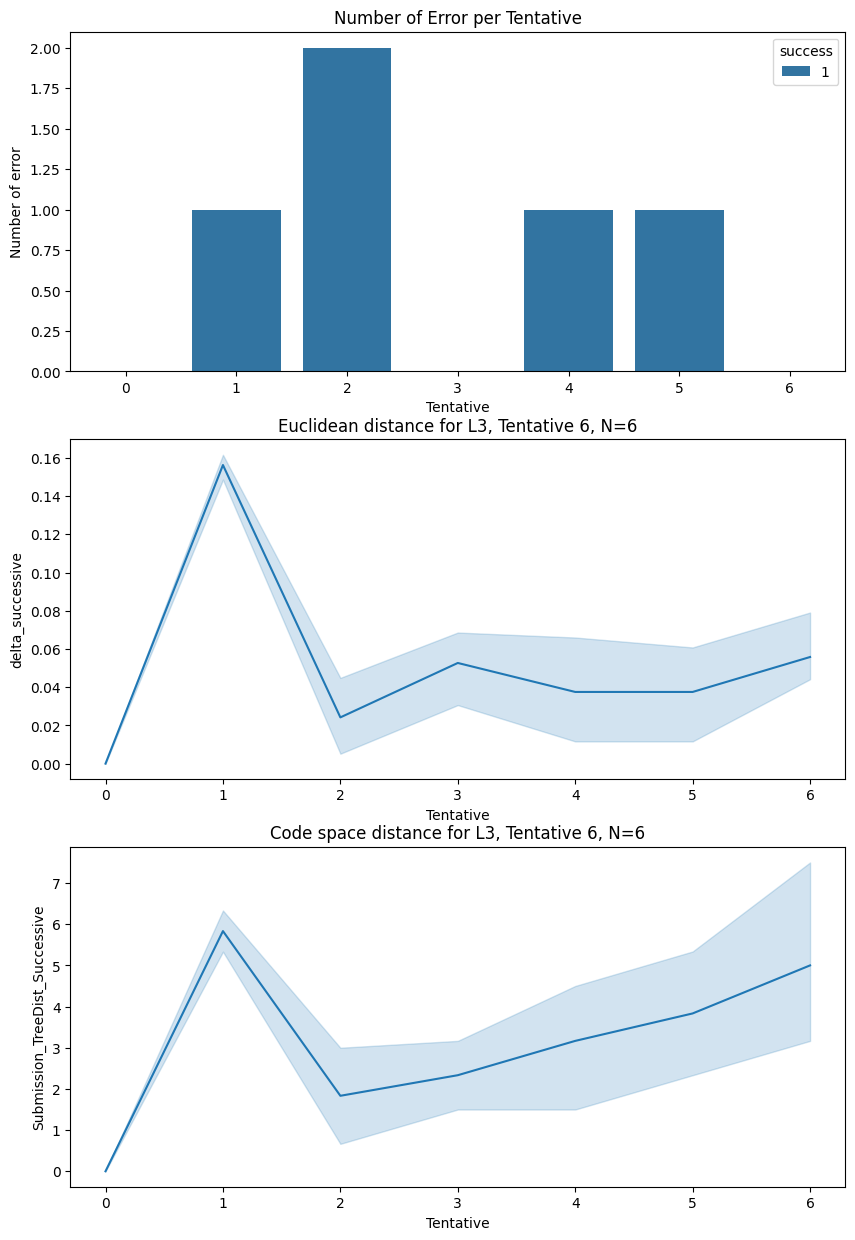

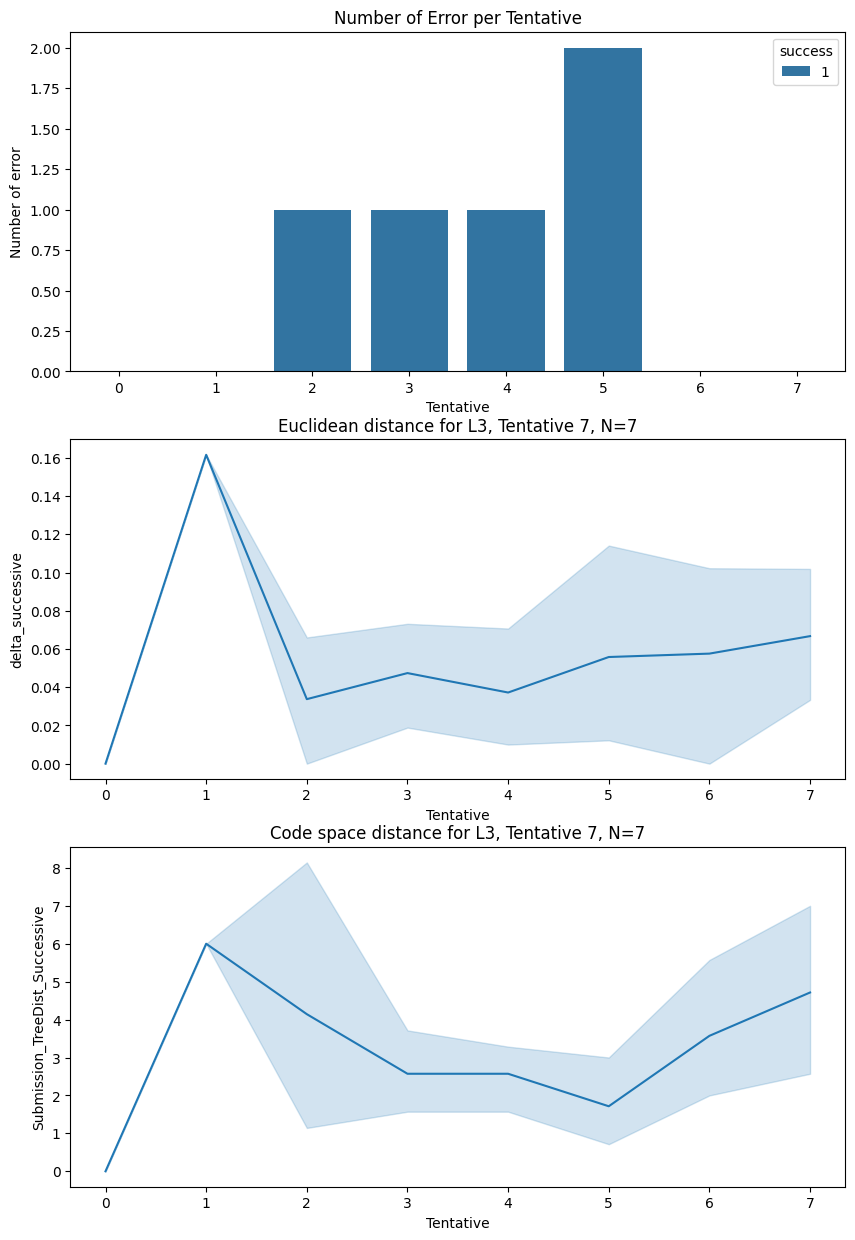

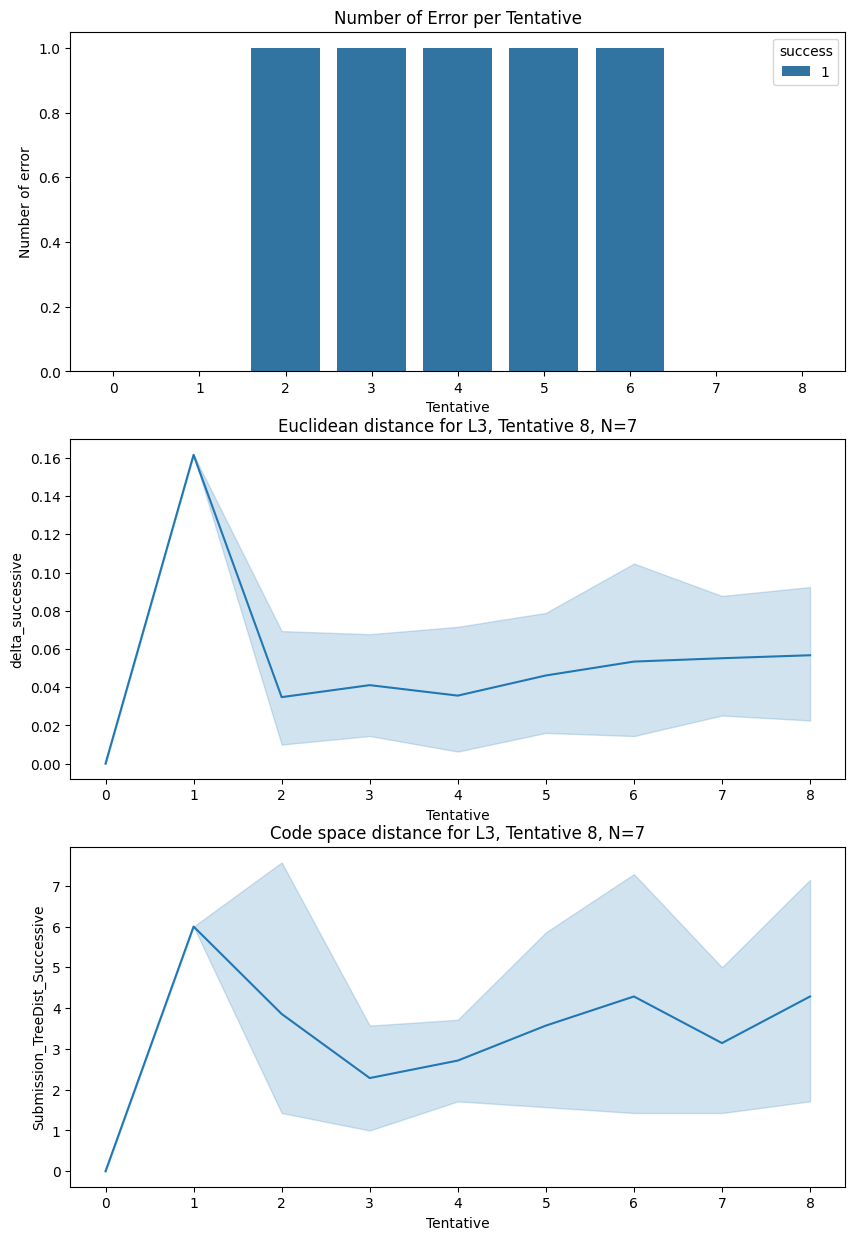

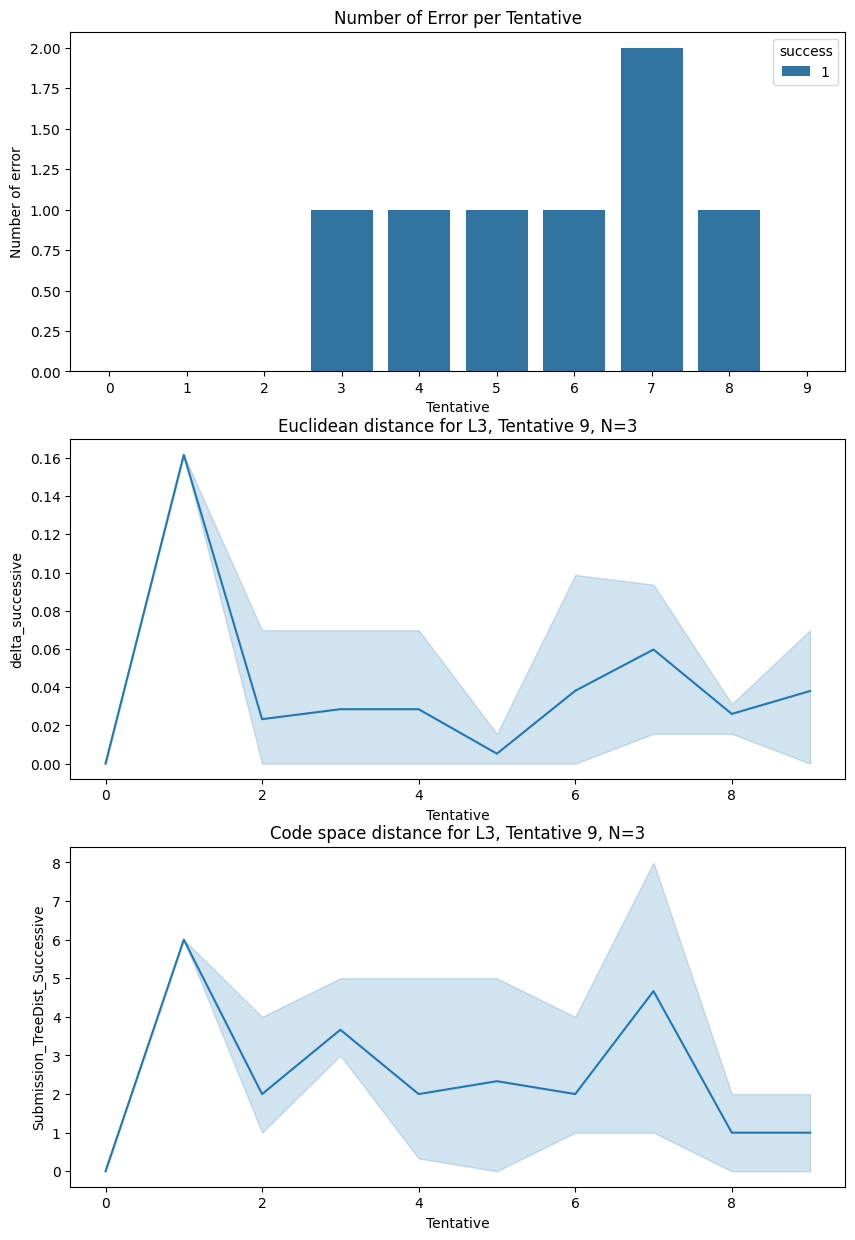

In [123]:
tentatives = [1, 2, 3, 4, 5, 6, 7, 8, 9]
datas = [data_l1, data_l2, data_l3]
data_names = ['L1', 'L2', 'L3']

for data, name in zip(datas, data_names):
    for i in range(len(tentatives)):

        data_filtered = data[data['nb_tentative'] <= 10]
        
        data_filtered_tentative = data_filtered[data_filtered['nb_tentative'] == tentatives[i]]
        data_success_tentative = data_filtered_tentative[data_filtered_tentative['success'] == 1]
        
        count_error_per_tentative_success = data_success_tentative.groupby('index').agg({'error': 'sum'}).reset_index()
        count_error_per_tentative_success['success'] = 1
        nb_success_student = len(data_success_tentative['Student ID'].unique())
        
        fig, axs = plt.subplots(3, 1, figsize=(10, 15))
        
        sns.barplot(x='index', y='error', hue='success', data=count_error_per_tentative_success, ax=axs[0])
        sns.lineplot(data=data_success_tentative, x='index', y='delta_successive', estimator='mean', ci=95, ax=axs[1], palette='Set2')
        sns.lineplot(data=data_success_tentative, x='index', y='Submission_TreeDist_Successive', estimator='mean', ci=95, ax=axs[2], palette='Set2')
    
        axs[0].set_xlabel('Tentative')
        axs[0].set_ylabel('Number of error')
        axs[0].set_title('Number of Error per Tentative')

        axs[1].set_title(f"Euclidean distance for {name}, Tentative {tentatives[i]}, N={nb_success_student}")
        axs[1].set_xlabel("Tentative")

        axs[2].set_title(f"Code space distance for {name}, Tentative {tentatives[i]}, N={nb_success_student}")
        axs[2].set_xlabel("Tentative")
        
        plt.show()

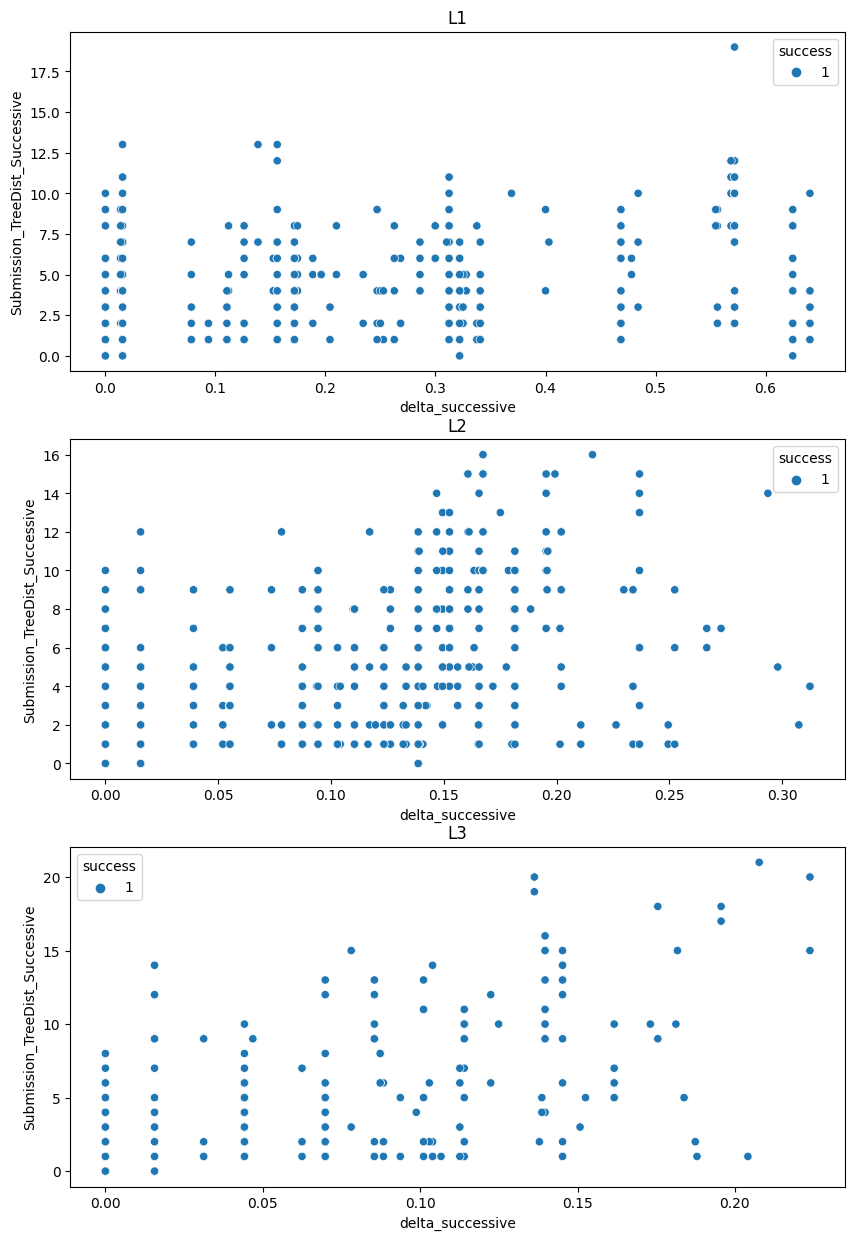

In [127]:
# scatter plot of euclidean distance and Submission_TreeDist_Successive

fig, axs = plt.subplots(3, 1, figsize=(10, 15))

data_l1_filtered = data_l1[data_l1['nb_tentative'] <= 10]
data_l2_filtered = data_l2[data_l2['nb_tentative'] <= 10]
data_l3_filtered = data_l3[data_l3['nb_tentative'] <= 10]

data_l1_success = data_l1_filtered[data_l1_filtered['success'] == 1]
data_l2_success = data_l2_filtered[data_l2_filtered['success'] == 1]
data_l3_success = data_l3_filtered[data_l3_filtered['success'] == 1]

sns.scatterplot(data=data_l1_success, x='delta_successive', y='Submission_TreeDist_Successive', hue='success', ax=axs[0])

sns.scatterplot(data=data_l2_success, x='delta_successive', y='Submission_TreeDist_Successive', hue='success', ax=axs[1])

sns.scatterplot(data=data_l3_success, x='delta_successive', y='Submission_TreeDist_Successive', hue='success', ax=axs[2])

axs[0].set_title("L1")
axs[1].set_title("L2")
axs[2].set_title("L3")

plt.show()


In [131]:
for df in [data_l1_success, data_l2_success, data_l3_success]:
    print(stats.pearsonr(df['delta_successive'], df['Submission_TreeDist_Successive']))

PearsonRResult(statistic=0.5062385541013249, pvalue=4.6764141799787284e-86)
PearsonRResult(statistic=0.624272883411167, pvalue=1.4343229975384032e-109)
PearsonRResult(statistic=0.6588506603353226, pvalue=5.524643482975697e-73)
